In [1]:
%pip install missingno

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import missingno as msno
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', 25)

### **Latar Belakang**

[TransJakarta, sebagai sistem _Bus Rapid Transit_ (BRT) pertama di Indonesia, diluncurkan pada tahun 2004](https://transjakarta.co.id/tentang/sejarah) dengan tujuan menyediakan transportasi massal yang efisien, terjangkau, dan ramah lingkungan. Sistem ini dirancang untuk mengurangi ketergantungan masyarakat pada kendaraan pribadi dan meningkatkan mobilitas perkotaan, namun masih menghadapi berbagai tantangan operasional yang mempengaruhi kualitas layanan. 

Beberapa masalah utama yang dihadapi adalah: [durasi perjalanan, kepadatan penumpang pada jam sibuk, kondisi infrastruktur yang memerlukan pemeliharaan, serta integrasi dengan moda transportasi lain](https://purejournal.ub.ac.id/index.php/pure/article/view/328/260). Tantangan-tantangan ini mempengaruhi kepuasan pengguna dan efektivitas keseluruhan sistem transportasi publik di Jakarta.

### **Pernyataan Masalah**

TransJakarta ingin menganalisis pola perjalanan penumpang untuk meningkatkan efisiensi operasional, terutama dalam pengalokasian armada dan penjadwalan rute. Analisis ini ditujukan untuk membantu `Tim Operasional dan Perencanaan` dalam `memahami pola perjalanan` berdasarkan faktor `waktu`, `rute`, dan `demografi penumpang`. Insight yang dihasilkan diharapkan dapat `mendukung pengambilan keputusan strategis` terkait `distribusi armada`, `penyesuaian rute`, dan `peningkatan layanan`.

Sebagai seorang _data analyst_, kita akan mencoba untuk menjawab pertanyaan berikut:


**"Bagaimana durasi perjalanan bervariasi terhadap arah tujuan, rute, waktu, dan karakteristik demografi penumpang TransJakarta?"**

### **Data Understanding**

In [3]:
tj_raw = pd.read_csv('D:/Bonifasius/Capstone Project (Data Analysis)/raw_dataset/Transjakarta.csv')
tj_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37900 entries, 0 to 37899
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   transID           37900 non-null  object 
 1   payCardID         37900 non-null  int64  
 2   payCardBank       37900 non-null  object 
 3   payCardName       37900 non-null  object 
 4   payCardSex        37900 non-null  object 
 5   payCardBirthDate  37900 non-null  int64  
 6   corridorID        36643 non-null  object 
 7   corridorName      35970 non-null  object 
 8   direction         37900 non-null  float64
 9   tapInStops        36687 non-null  object 
 10  tapInStopsName    37900 non-null  object 
 11  tapInStopsLat     37900 non-null  float64
 12  tapInStopsLon     37900 non-null  float64
 13  stopStartSeq      37900 non-null  int64  
 14  tapInTime         37900 non-null  object 
 15  tapOutStops       35611 non-null  object 
 16  tapOutStopsName   36556 non-null  object

In [4]:
display(
    tj_raw['tapInTime'].dtype,
    tj_raw['tapOutTime'].dtype,
    pd.to_datetime(tj_raw['tapInTime']).agg(['min','max']),
    pd.to_datetime(tj_raw['tapOutTime']).agg(['min','max'])
)

dtype('O')

dtype('O')

min   2023-04-01 06:22:27
max   2023-04-30 21:55:41
Name: tapInTime, dtype: datetime64[ns]

min   2023-04-01 07:27:31
max   2023-04-30 23:23:18
Name: tapOutTime, dtype: datetime64[ns]

##### **Dataset Dictionary**

Dataset ini berisi informasi terkait *record* penumpang BRT *(Bus Rapid Transit)* TransJakarta selama 1 bulan, tepatnya di bulan April tahun 2023.

Ada 22 kolom di dalam dataset Transjakarta, yaitu:
- `transID`         : ID transaksi unik untuk setiap transaksi.

- `payCardID`       : ID pelanggan yang tertera di kartu pembayaran.

- `payCardBank`     : Nama bank penerbit kartu pelanggan.

- `payCardName`     : Nama pelanggan yang tercatat di kartu.

- `payCardSex`      : Jenis kelamin pelanggan yang tercatat di kartu.

- `payCardBirthDate`: Tahun kelahiran pelanggan.

- `corridorID`      : ID koridor/rute sebagai kunci pengelompokkan rute.

- `corridorName`    : Nama koridor/rute, termasuk titik mulai dan selesai.

- `direction`       : 0 untuk arah pergi, 1 untuk arah kembali.

- `tapInStops`      : ID halte tap-in (masuk) untuk mengidentifikasi nama halte.

- `tapInStopsName`  : Nama halte tap-in (masuk).

- `tapInStopsLat`   : Latitude halte tap-in.

- `tapInStopsLon`   : Longitude halte tap-in.

- `stopStartSeq`    : Urutan halte yang dikunjungi, terkait dengan arah perjalanan.

- `tapInTime`       : Waktu tap-in, tanggal dan jam.

- `tapOutStops`     : ID halte tap-out (keluar) untuk mengidentifikasi nama halte.

- `tapOutStopsName` : Nama halte tap-out (keluar).

- `tapOutStopsLat`  : Latitude halte tap-out.

- `tapOutStopsLon`  : Longitude halte tap-out.

- `stopEndSeq`      : Urutan halte yang dikunjungi, terkait dengan arah perjalanan.

- `tapOutTime`      : Waktu tap-out, tanggal dan jam.

- `payAmount`       : Jumlah pembayaran yang dilakukan pelanggan, ada yang gratis, ada yang berbayar.

Berikut 5 baris teratas dan terbawah dari dataset Transjakarta.

In [5]:
display(tj_raw.head(2), tj_raw.tail(2))

,transID,payCardID,payCardBank,payCardName,payCardSex,payCardBirthDate,corridorID,corridorName,direction,tapInStops,tapInStopsName,tapInStopsLat,tapInStopsLon,stopStartSeq,tapInTime,tapOutStops,tapOutStopsName,tapOutStopsLat,tapOutStopsLon,stopEndSeq,tapOutTime,payAmount
0,EIIW227B8L34VB,180062659848800,emoney,Bajragin Usada,M,2008,5,Matraman Baru - Ancol,1.0,P00142,Pal Putih,-6.184631,106.84402,7,2023-04-03 05:21:44,P00253,Tegalan,-6.203101,106.85715,12.0,2023-04-03 06:00:53,3500.0
1,LGXO740D2N47GZ,4885331907664776,dki,Gandi Widodo,F,1997,6C,Stasiun Tebet - Karet via Patra Kuningan,0.0,B01963P,Kemenkes 2,-6.228700,106.83302,13,2023-04-03 05:42:44,B03307P,Sampoerna Strategic,-6.217152,106.81892,21.0,2023-04-03 06:40:01,3500.0


,transID,payCardID,payCardBank,payCardName,payCardSex,payCardBirthDate,corridorID,corridorName,direction,tapInStops,tapInStopsName,tapInStopsLat,tapInStopsLon,stopStartSeq,tapInTime,tapOutStops,tapOutStopsName,tapOutStopsLat,tapOutStopsLon,stopEndSeq,tapOutTime,payAmount
37898,RGVK175U2U98UV,377840859133591,emoney,Ana Agustina,M,1976,JAK.13,Tanah Abang - Jembatan Lima,1.0,B02505P,Museum Textile,-6.188656,106.80954,33,2023-04-15 19:59:26,B01787P,JPO Blok G,-6.188861,106.81135,34.0,2023-04-15 20:27:50,0.0
37899,FMZZ963S4B68ZP,501862539795,flazz,drg. Leo Najmudin,F,1985,13,Ciledug - Tendean,0.0,P00001,Adam Malik,-6.236466,106.74786,2,2023-04-12 21:08:12,P00106,Kebayoran Lama,-6.238340,106.77752,7.0,2023-04-12 21:34:53,3500.0


##### **Inspeksi Dataset**

Mari kita mulai dengan melakukan inspeksi terhadap dataset Transjakarta. Selain agar dapat lebih mengetahui isi nilai dari setiap kolomnya, kita juga berupaya untuk menemukan anomali dan cara untuk menanganinya lebih lanjut di tahapan _data cleaning._ Setiap tindakan yang dilakukan, akan disertai dengan justifikasi langkah yang diambil, baik secara _domain knowledge_ maupun secara statistik.

In [6]:
print(f'Bentuk dataset: {tj_raw.shape[0]} baris & {tj_raw.shape[1]} kolom.\n')

display(tj_raw.iloc[:,3:].describe(), tj_raw.describe(include='object'))

Bentuk dataset: 37900 baris & 22 kolom.



,payCardBirthDate,direction,tapInStopsLat,tapInStopsLon,stopStartSeq,tapOutStopsLat,tapOutStopsLon,stopEndSeq,payAmount
count,37900.000000,37900.000000,37900.000000,37900.000000,37900.000000,36556.000000,36556.000000,36556.000000,36893.000000
mean,1990.089314,0.500633,-6.214838,106.841554,13.572480,-6.214651,106.841233,21.219909,2699.712683
std,13.051482,0.500006,0.057911,0.060369,12.237623,0.059022,0.060999,13.800689,4212.225592
min,1946.000000,0.000000,-6.394973,106.614730,0.000000,-6.394973,106.614730,1.000000,0.000000
25%,1982.000000,0.000000,-6.245863,106.803470,4.000000,-6.247225,106.801750,11.000000,0.000000
50%,1990.000000,1.000000,-6.214587,106.834830,10.000000,-6.214718,106.834580,18.000000,3500.000000
75%,2001.000000,1.000000,-6.175528,106.882270,19.000000,-6.174736,106.883030,29.000000,3500.000000
max,2012.000000,1.000000,-6.089429,107.023950,68.000000,-6.091746,107.023660,77.000000,20000.000000


,transID,payCardBank,payCardName,payCardSex,corridorID,corridorName,tapInStops,tapInStopsName,tapInTime,tapOutStops,tapOutStopsName,tapOutTime
count,37900,37900,37900,37900,36643,35970,36687,37900,37900,35611,36556,36556
unique,37900,6,1993,2,221,216,2570,2602,37079,2230,2248,35908
top,EIIW227B8L34VB,dki,Suci Wacana,F,1T,Cibubur - Balai Kota,P00170,Penjaringan,2023-04-06 17:35:40,P00016,BKN,2023-04-24 06:53:50
freq,1,18743,80,20157,400,391,236,243,3,306,316,3


Tampaknya ada *records* yang bernilai `0 atau gratis`. Mari kita investigasi lebih lanjut.

In [7]:
display(
    tj_raw[tj_raw['payAmount'] == 0].shape,
    tj_raw[tj_raw['payAmount'] == 0].sample(3)
)

(16648, 22)

,transID,payCardID,payCardBank,payCardName,payCardSex,payCardBirthDate,corridorID,corridorName,direction,tapInStops,tapInStopsName,tapInStopsLat,tapInStopsLon,stopStartSeq,tapInTime,tapOutStops,tapOutStopsName,tapOutStopsLat,tapOutStopsLon,stopEndSeq,tapOutTime,payAmount
7449,NSGA822R0O13DC,3535601073732219,dki,R. Unggul Halimah,F,1986,JAK.64,Lenteng Agung - Aseli,1.0,B03899P,Sbr. Kec. Jagakarsa,-6.334583,106.82160,19,2023-04-19 06:02:50,B00868P,Jln. Aselih,-6.347277,106.79695,37.0,2023-04-19 06:35:29,0.0
37605,GBFW072V7E05FE,4721230793157234,dki,Safina Lazuardi,M,2008,11C,Rusun Pinus Elok - Rusun Pulo Gebang,0.0,B04898P,Simpang Kampung Jembatan 2,-6.208426,106.93576,5,2023-04-06 06:03:19,B06654P,Walikota Jakarta Timur 1,-6.212327,106.94515,8.0,2023-04-06 08:46:08,0.0
31513,ZQFW981N7S00UD,30545912633714,bni,"Tgk. Mila Wibisono, S.IP",F,1982,JAK.41,Kampung Melayu - Pulo Gadung,0.0,B04303P,Sbr. Rukan Balai Pustaka,-6.198728,106.88593,31,2023-04-28 20:03:40,B05306P,SMK Tunas Markatin,-6.196619,106.88842,33.0,2023-04-28 21:53:14,0.0


Mengacu kepada kolom `corridorID`, kita sekarang mengetahui dan juga dapat kita validasi dengan *domain knowledge* terkait layanan TransJakarta, bahwa dataset ini juga terdiri dari *records* layanan [Jaklingko](https://money.kompas.com/read/2023/03/13/140000226/naik-angkot-jaklingko-masih-gratis-), dan layanan gratis [TJ Card](https://smartcity.jakarta.go.id/id/blog/gratis-naik-transjakarta-untuk-kamu-dengan-15-kriteria-ini/) dengan kriteria penumpang tertentu.

Selanjutnya, kita akan coba memahami durasi perjalanan penumpang TransJakarta. Pertama-tama, mari kita rubah tipe data kolom `tapInTime` dan `tapOutTime` dari `object` menjadi `datetime`. Lalu kita akan cek apakah ada anomali dari kedua kolom tersebut.

In [8]:
tj_raw['tapInTime'] = pd.to_datetime(tj_raw['tapInTime'], format='%Y-%m-%d %H:%M:%S')
tj_raw['tapOutTime'] = pd.to_datetime(tj_raw['tapOutTime'], format='%Y-%m-%d %H:%M:%S')

tj_raw[['tapInTime','tapOutTime']].dtypes

tapInTime     datetime64[ns]
tapOutTime    datetime64[ns]
dtype: object

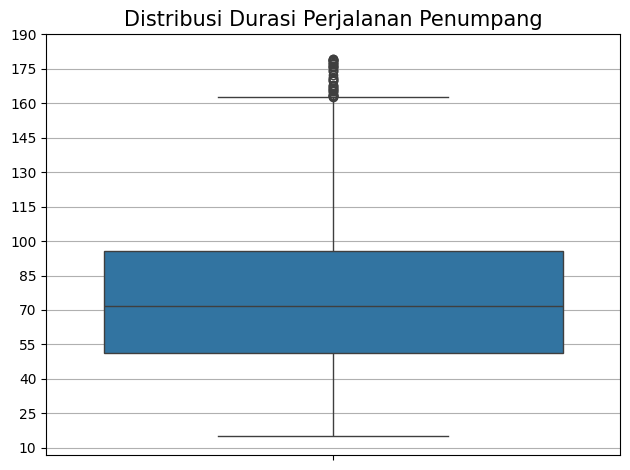

In [9]:
anomali_waktu = round((tj_raw['tapOutTime'] - tj_raw['tapInTime']).dt.total_seconds() / 60, 2)
sns.boxplot(anomali_waktu)
plt.yticks(range(10,195,15))
plt.grid(axis='y')
plt.title('Distribusi Durasi Perjalanan Penumpang', size=15)

plt.tight_layout();

Berdasarkan interval waktu perjalanan penumpang, terdapat `44 rows` yang memiliki anomali durasi perjalanan tidak wajar. Kita akan dokumentasikan terlebih dahulu dengan cara menyimpan `index` dari anomali ini. Kita investigasi serta tindak lanjuti pada tahapan *data cleansing* karena durasi perjalanan penumpang menjadi salah satu bagian penting dalam proses analisis yang akan kita lakukan nanti.

In [10]:
index_anomali_waktu = anomali_waktu[anomali_waktu > 160].index

display(
    len(anomali_waktu[index_anomali_waktu]),
    index_anomali_waktu
)

44

Index([37605, 37608, 37614, 37615, 37616, 37619, 37623, 37632, 37633, 37651,
       37661, 37663, 37665, 37672, 37674, 37681, 37692, 37702, 37710, 37719,
       37720, 37742, 37744, 37752, 37753, 37758, 37761, 37784, 37806, 37822,
       37824, 37831, 37837, 37851, 37859, 37861, 37867, 37871, 37874, 37875,
       37878, 37883, 37891, 37897],
      dtype='int64')

Selanjutnya mari kita cek untuk memastikan apakah terdapat duplikat data atau tidak pada dataset TransJakarta.

In [11]:
# tj_raw[tj_raw['payCardID'].duplicated()].head() # 4885331907664776, dki, Gandi Widodo, Sawo Kecik Raya, 2023-04-03 17:35:45, 2023-04-03 19:00:15

tj_raw[tj_raw['payCardID'].duplicated(keep=False)].head()

,transID,payCardID,payCardBank,payCardName,payCardSex,payCardBirthDate,corridorID,corridorName,direction,tapInStops,tapInStopsName,tapInStopsLat,tapInStopsLon,stopStartSeq,tapInTime,tapOutStops,tapOutStopsName,tapOutStopsLat,tapOutStopsLon,stopEndSeq,tapOutTime,payAmount
0,EIIW227B8L34VB,180062659848800,emoney,Bajragin Usada,M,2008,5,Matraman Baru - Ancol,1.0,P00142,Pal Putih,-6.184631,106.84402,7,2023-04-03 05:21:44,P00253,Tegalan,-6.203101,106.85715,12.0,2023-04-03 06:00:53,3500.0
1,LGXO740D2N47GZ,4885331907664776,dki,Gandi Widodo,F,1997,6C,Stasiun Tebet - Karet via Patra Kuningan,0.0,B01963P,Kemenkes 2,-6.228700,106.83302,13,2023-04-03 05:42:44,B03307P,Sampoerna Strategic,-6.217152,106.81892,21.0,2023-04-03 06:40:01,3500.0
2,DJWR385V2U57TO,4996225095064169,dki,Emong Wastuti,F,1992,R1A,Pantai Maju - Kota,0.0,B00499P,Gg. Kunir II,-6.133132,106.81435,38,2023-04-03 05:59:06,B04962P,Simpang Kunir Kemukus,-6.133731,106.81475,39.0,2023-04-03 06:50:55,3500.0
3,JTUZ800U7C86EH,639099174703,flazz,Surya Wacana,F,1978,11D,Pulo Gebang - Pulo Gadung 2 via PIK,0.0,B05587P,Taman Elok 1,-6.195743,106.93526,23,2023-04-03 05:44:51,B03090P,Raya Penggilingan,-6.183068,106.93194,29.0,2023-04-03 06:28:16,3500.0
4,VMLO535V7F95NJ,570928206772,flazz,Embuh Mardhiyah,M,1982,12,Tanjung Priok - Pluit,0.0,P00239,Sunter Boulevard Barat,-6.149650,106.88900,5,2023-04-03 06:17:35,P00098,Kali Besar Barat,-6.135355,106.81143,15.0,2023-04-03 06:57:03,3500.0


In [12]:
display(
    tj_raw['transID'].duplicated().sum(), 
    tj_raw['payCardID'].duplicated().sum(), 
    tj_raw['payCardName'].duplicated().sum()
)

np.int64(0)

np.int64(35900)

np.int64(35907)

Dari sini kita dapat memahami bahwa dataset TransJakarta ini tidak terdapat duplikat, namun terdapat transaksi berulang dari *loyal customer* atau penumpang yang secara rutin memang menggunakan layanan Transjakarta untuk opsi transportasi utama mereka. Oleh karena itu, temuan ini akan kita biarkan karena *records* tersebut merupakan data yang valid.

In [13]:
pd.set_option('display.max_colwidth', 30)
unique_items = []

for col in tj_raw.columns :
    unique_items.append( [col, tj_raw[col].nunique(), tj_raw[col].unique()])

raw_desc = pd.DataFrame(columns=['Column Name', 'Number of Unique', 'Unique Sample'],
                     data=unique_items)
raw_desc

,Column Name,Number of Unique,Unique Sample
0,transID,37900,"[EIIW227B8L34VB, LGXO740D2..."
1,payCardID,2000,"[180062659848800, 48853319..."
2,payCardBank,6,"[emoney, dki, flazz, onlin..."
3,payCardName,1993,"[Bajragin Usada, Gandi Wid..."
4,payCardSex,2,"[M, F]"
5,payCardBirthDate,67,"[2008, 1997, 1992, 1978, 1..."
6,corridorID,221,"[5, 6C, R1A, 11D, 12, 1T, ..."
7,corridorName,216,"[Matraman Baru - Ancol, St..."
8,direction,2,"[1.0, 0.0]"
9,tapInStops,2570,"[P00142, B01963P, B00499P,..."


Dari hasil inspeksi yang telah kita lakukan, dapat disimpulkan bahwa:

- Dataset Transjakarta memiliki 37.900 baris & 22 kolom
- beberapa kolom, seperti: `corridorID`, `corridorName`, `tapInStops`, `tapOutStops`, `tapOutStopsName`, `tapOutStopsLat`, `tapOutStopsLon`, `stopEndSeq`, `tapOutTime`, dan `payAmount` memiliki data kosong. Data kosong pada kolom-kolom tersebut diwakili dengan data `NaN`.
- Kolom `transID` memiliki 37900 nilai unik yang menunjukkan tidak terdapat transaksi duplikat pada dataset ini. Tetapi berdasarkan kolom `payCardID	` dan `payCardName`, terdapat catatan transaksi dari penumpang yang sama yang menggunakan layanan Transjakarta secara rutin.
- Kolom `payCardID`, `tapInStops`, dan `tapOutStops` berisikan ID unik untuk setiap kartu pembayaran, halde tap-in/tap-out penumpang, yang sudah terwakilkan keterangannya pada beberapa kolom lain. Oleh karena itu kolom `transID`, `tapInStops`, dan `tapOutStops` kurang relevan untuk analisis dan dapat kita _drop_ saja.
- Terdapat anomali di interval durasi perjalanan penumpang, mempertimbangkan untuk membuat kolom baru dari agregasi kolom `tapInTime` dan `tapOutTime` yang akan berisi durasi perjalanan dalam satuan menit agar dapat ditangani lebih lanjut.
- Beberapa kolom seperti: `tapOutStopsName, tapOutStopsLat, tapOutStopsLon, stopEndSeq, tapOutTime` mengandung jumlah `NaN` yang sama. Kita dapat asumsikan diawal bahwa setiap _missing value_ dari 5 kolom tersebut berada di _row_ yang sama. Kita akan cek dan pastikan lebih lanjut.
- Kolom `payCardBirthDate` dapat kita manfaatkan untuk mencari umur dari setiap penumpang (`2023 - payCardBirthDate`). Kita sesuaikan dimensi waktu karena dataset ini hanya berisikan *records* penumpang Transjakarta di bulan April tahun 2023.

### **Data Cleansing**

Kita *assign* dataset Transjakarta ke variabel baru, agar perubahan yang kita lakukan lebih leluasa dan efisien. Misalnya, jika sewaktu-waktu kita melakukan perubahan yang `berakibat fatal` ke proses analisis, kita dapat kembali ke bentuk dataset awal dengan mudah.

In [14]:
df_tj = tj_raw.copy()

##### **Missing Value Check**

In [15]:
df_missing = pd.DataFrame(df_tj.isna().sum()).rename(columns={0:'missingCount'})
df_missing['missingPercentage'] = round((df_missing['missingCount'] / len(df_tj)), 4) * 100
df_missing

,missingCount,missingPercentage
transID,0,0.00
payCardID,0,0.00
payCardBank,0,0.00
payCardName,0,0.00
payCardSex,0,0.00
payCardBirthDate,0,0.00
corridorID,1257,3.32
corridorName,1930,5.09
direction,0,0.00
tapInStops,1213,3.20


##### **Missing Value Distribution Check**

<Axes: >

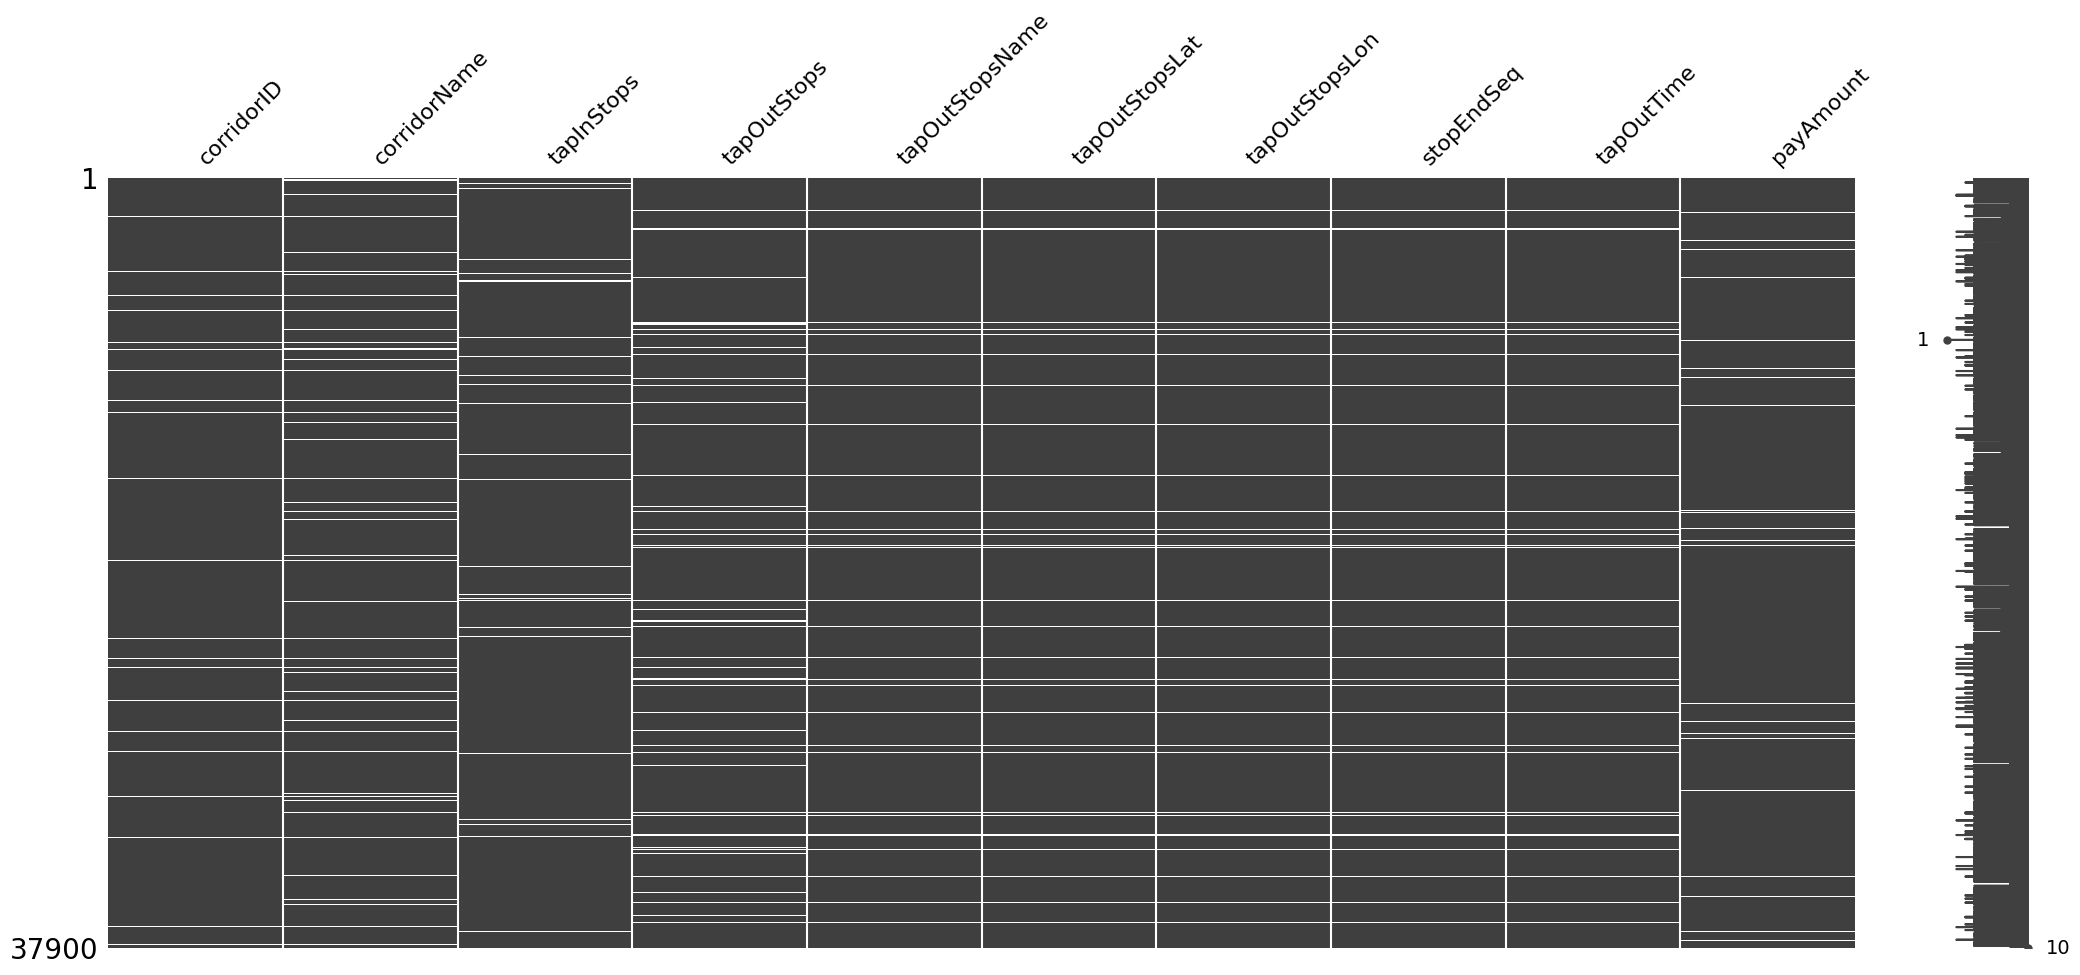

In [16]:
msno.matrix(df_tj[
                  ['corridorID', 'corridorName',
                  'tapInStops',
                  'tapOutStops', 'tapOutStopsName',
                  'tapOutStopsLat', 'tapOutStopsLon',
                  'stopEndSeq', 'tapOutTime',
                  'payAmount']
                  ]
            )

<Axes: >

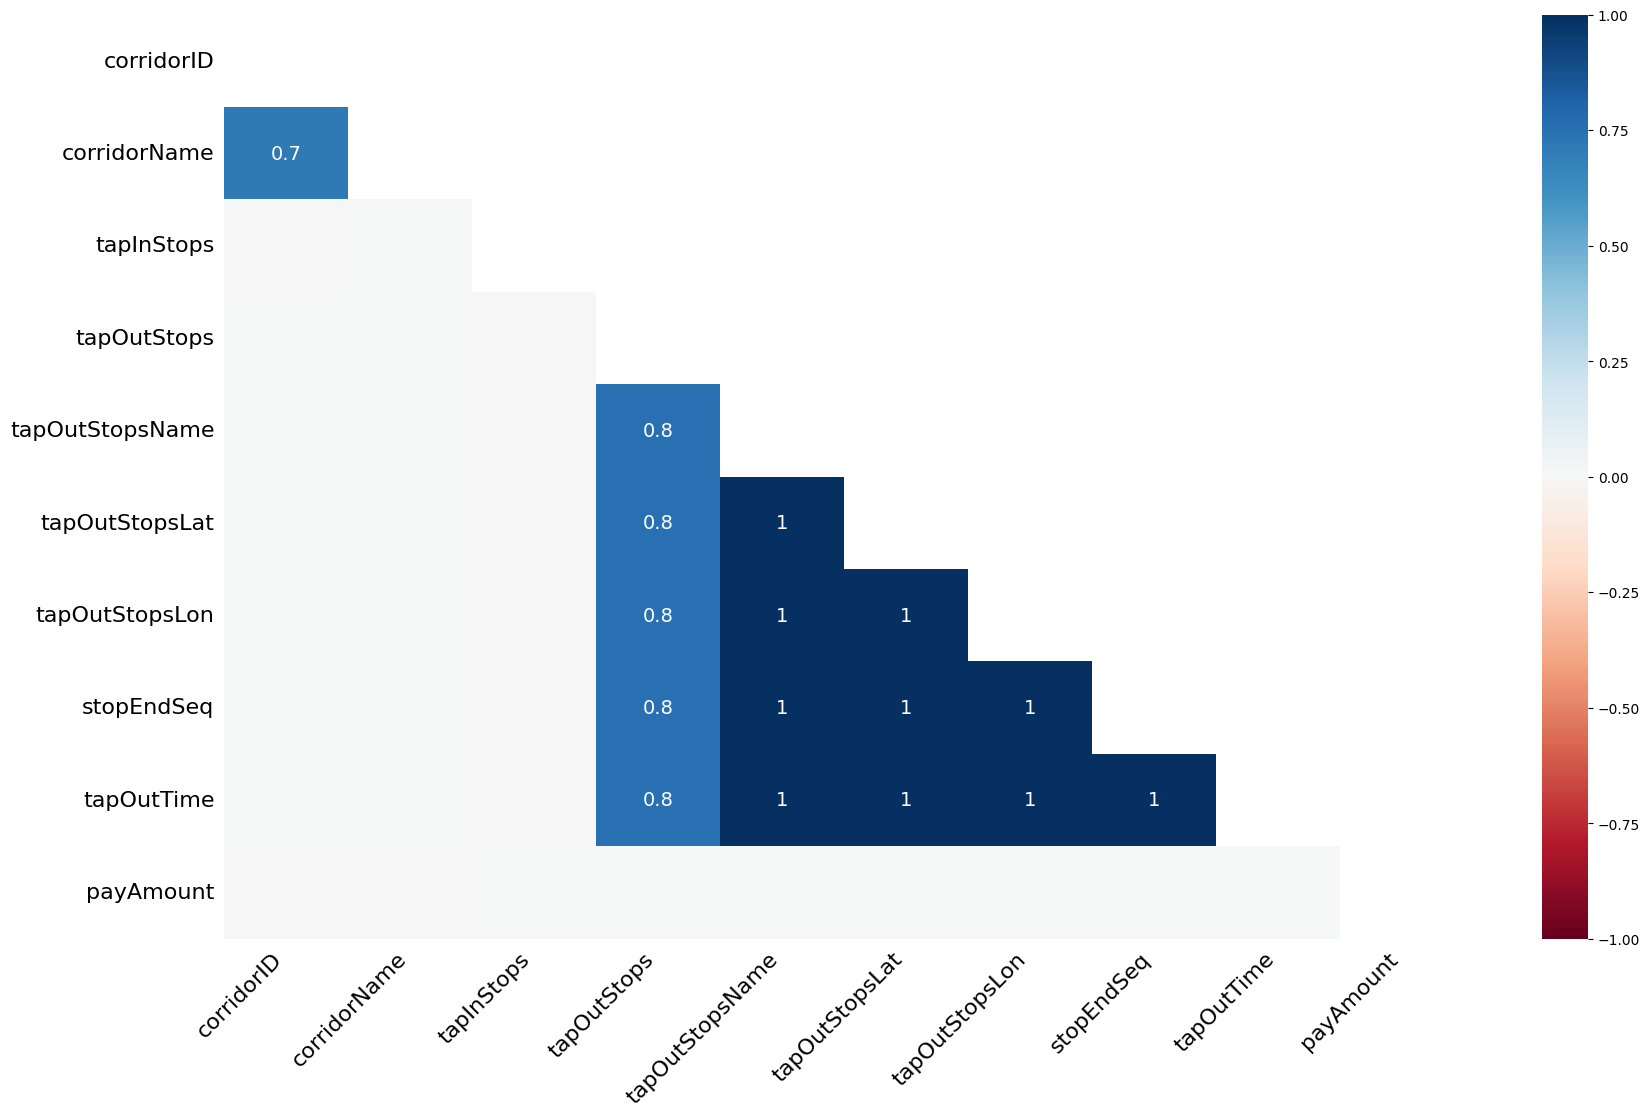

In [17]:
msno.heatmap(df_tj)

Secara garis besar:  
* Persentase *missing value* dari dataset Transjakarta hanya terdiri _kurang dari 10%_ dari setiap kolomnya. Dengan kolom `tapOutStops` yang memiliki _missing value_ terbanyak dengan persentase sebesar 6.04%
* *missing value* di kolom : `tapOutStopsName, tapOutStopsLat, tapOutStopsLon`, dan kolom `stopEndSeq` memiliki *missing values* yang saling berkaitan. Dengan kata lain, *missing value* dari berbagai kolom ini berada di row yang sama.

Ada beberapa cara untuk menangani *missing value*:

1. Jika persentase missing < 5% : `delete row`
1. 5-20% : `simple imputation` (mean, median, modus, constant)
1. 20-50% : `advanced immputer` (KKN, iterative imputer)
1. Jika persentase missing > 50% : `delete column`

* Kolom `corridorID`, `tapInStops`, dan `tapOutStops` dapat kita *drop*/biarkan saja karena bukan termasuk bagian yang dapat kita analisis (*column to drop*)
* Untuk `tapOutStopsName, tapOutStopsLat, tapOutStopsLon`, dan kolom `stopEndSeq`, tidak bisa langsung kita `dropna` karena *missing value* dari kolom-kolom tersebut saling berkaitan. Oleh karena itu, kita perlu melakukan imputasi untuk mengisi *missing value*.
* *Missing value* di kolom `payAmount` juga masih dapat kita isi dengan *domain knowledge* tarif Transjakarta yaitu dengan harga *flat* 3500 untuk setiap kali *tap in*. Dimana kita asumsikan, seharusnya *median* dan *mode* dari kolom `payAmount` juga merupakan 3500.

##### **Handle Missing Value**

Kita akan mulai mencoba imputasi ke kolom kategori yang terdapat *missing values* yaitu: `corridorName` dan `tapOutStopsName`. Mari kita mulai dari kolom `tapOutStopsName` karena kolom ini akan menjadi acuan saat kita imputasi kolom `corridorName` selanjutnya.

Untuk cara imputasi yang kita gunakan adalah mencoba mengisi *missing values* dengan menjadikan kolom lain sebagai acuan `SimpleImputer (most_frequent)`.

Imputasi akan dilakukan dengan data yang sudah ada, berdasarkan kolom-kolom yang saling berkorelasi, ataupun dengan *domain knowledge*. Tujuan imputasi ini agar persentase *missing values* pada dataset Transjakarta tidak ada yang melebihi 5%. Terakhir, dari sisa-sisa dari *missing values* nantinya dapat kita *drop*.

In [18]:
# df_tj.groupby(['direction','tapInStopsName'])['tapOutStopsName'] \
#     .transform(lambda x: x.fillna(x.mode().iloc[0]) if not x.mode().empty else x)

In [19]:
mode_imputer = SimpleImputer(strategy='most_frequent')

df_tj['tapOutStopsName'] = df_tj.groupby(['direction','tapInStopsName'])['tapOutStopsName'] \
    .transform(lambda x: mode_imputer.fit_transform(x.values.reshape(-1, 1)).ravel() if not x.mode().empty else x)

In [20]:
display(
    tj_raw['tapOutStopsName'].isna().sum(), 
    df_tj['tapOutStopsName'].isna().sum()
)

np.int64(1344)

np.int64(46)

Selanjutnya kita coba isi *missing values* di kolom `corridorName` dengan menjadikan kolom `tapinStopsName` dan `tapOutStopsName` sebagai acuannya.

In [21]:
df_tj['corridorName'] = df_tj.groupby(['direction','tapInStopsName','tapOutStopsName'])['corridorName'] \
    .transform(lambda x: mode_imputer.fit_transform(x.values.reshape(-1, 1)).ravel() if not x.mode().empty else x)

In [22]:
display(
    tj_raw[['corridorName','tapOutStopsName']].isna().sum(), 
    df_tj[['corridorName','tapOutStopsName']].isna().sum()
)

corridorName       1930
tapOutStopsName    1344
dtype: int64

corridorName       174
tapOutStopsName     46
dtype: int64

Kita coba cek hasilnya apakah masuk akal atau tidak berdasarkan *domain knowledge* kita terhadap daerah dan ruas jalan di kota Jakarta.

In [23]:
display(
    tj_raw[(tj_raw['corridorName'].isna()) & (tj_raw['tapOutStopsName'].isna())][['corridorName','direction','tapInStopsName','tapOutStopsName']].head(),
    df_tj.iloc[[826,837,876,1395,2646]][['corridorName','direction','tapInStopsName','tapOutStopsName']]
    )

,corridorName,direction,tapInStopsName,tapOutStopsName
826,NaN,1.0,Stasiun Jatinegara Arah Utara,NaN
837,NaN,0.0,Ragunan,NaN
876,NaN,1.0,Jln. Prima,NaN
1395,NaN,1.0,Cut Meutia,NaN
2646,NaN,0.0,Tol Bekasi Timur 1,NaN


,corridorName,direction,tapInStopsName,tapOutStopsName
826,Tanjung Priok - PGC 2,1.0,Stasiun Jatinegara Arah Utara,Permai Koja Arah Utara
837,Ragunan - Gelora Bung Karno,0.0,Ragunan,Tendean
876,Rawa Buaya - Rawa Kompeni,1.0,Jln. Prima,Sbr. SMAN 95
1395,Gondangdia - Senen,1.0,Cut Meutia,Selatan St. Gondangdia
2646,Bekasi Timur - Cawang,0.0,Tol Bekasi Timur 1,BNN LRT


Selanjutnya kita akan coba `IterativeImputer` terhadap kolom numerik seperti `tapOutStopsLat`, `tapOutStopsLon`, `stopEndSeq`, dan `tapOutTime` dengan mengacu kepada empat kolom saat penumpang melakukan *tap-in.*

**TapOutStopsLat & TapOutStopsLat**

In [24]:
col_to_validate = ['corridorName','direction','stopStartSeq','tapInTime','tapOutStopsLat','tapOutStopsLon','stopEndSeq','tapOutTime','payAmount']

In [25]:
# Define imputer
iter_imputer = IterativeImputer()

# Fit imputer
iter_imputer.fit(df_tj[['tapOutStopsLat','tapInStopsLat']])

,estimator,None
,missing_values,nan
,sample_posterior,False
,max_iter,10
,tol,0.001
,n_nearest_features,None
,initial_strategy,'mean'
,fill_value,None
,imputation_order,'ascending'
,skip_complete,False
,min_value,-inf


In [26]:
# Transform
df_tj['tapOutStopsLat'] = iter_imputer.transform(df_tj[['tapOutStopsLat','tapInStopsLat']])
df_tj['tapOutStopsLat'] = df_tj['tapOutStopsLat'].astype('float64')

In [27]:
iter_imputer.fit(df_tj[['tapOutStopsLon','tapInStopsLon']])

,estimator,None
,missing_values,nan
,sample_posterior,False
,max_iter,10
,tol,0.001
,n_nearest_features,None
,initial_strategy,'mean'
,fill_value,None
,imputation_order,'ascending'
,skip_complete,False
,min_value,-inf


In [28]:
df_tj['tapOutStopsLon'] = iter_imputer.transform(df_tj[['tapOutStopsLon','tapInStopsLon']])
df_tj['tapOutStopsLon'] = df_tj['tapOutStopsLon'].astype('float64')

**StopEndSeq**

In [29]:
iter_imputer.fit(df_tj[['stopEndSeq','stopStartSeq']])

,estimator,None
,missing_values,nan
,sample_posterior,False
,max_iter,10
,tol,0.001
,n_nearest_features,None
,initial_strategy,'mean'
,fill_value,None
,imputation_order,'ascending'
,skip_complete,False
,min_value,-inf


In [30]:
df_tj['stopEndSeq'] = iter_imputer.transform(df_tj[['stopEndSeq','stopStartSeq']])
df_tj['stopEndSeq'] = df_tj['stopEndSeq'].astype('int64')

Mari kita cek hasilnya

In [31]:
display(
    tj_raw[tj_raw['stopEndSeq'].isna()][col_to_validate].head(),
    df_tj.iloc[[6,30,70,130,192]][col_to_validate]
    )

,corridorName,direction,stopStartSeq,tapInTime,tapOutStopsLat,tapOutStopsLon,stopEndSeq,tapOutTime,payAmount
6,Kalibata - Kuningan,0.0,25,2023-04-03 06:58:21,NaN,NaN,NaN,NaT,0.0
30,Pasar Minggu - Jagakarsa,1.0,19,2023-04-03 06:14:02,NaN,NaN,NaN,NaT,0.0
70,Cibubur - Balai Kota,0.0,7,2023-04-03 05:57:55,NaN,NaN,NaN,NaT,20000.0
130,Kampung Rambutan - Tanjung...,0.0,7,2023-04-03 05:40:04,NaN,NaN,NaN,NaT,3500.0
192,Kalideres - Gelora Bung Karno,0.0,11,2023-04-03 06:15:53,NaN,NaN,NaN,NaT,3500.0


,corridorName,direction,stopStartSeq,tapInTime,tapOutStopsLat,tapOutStopsLon,stopEndSeq,tapOutTime,payAmount
6,Kalibata - Kuningan,0.0,25,2023-04-03 06:58:21,-6.223368,106.850358,31,NaT,0.0
30,Pasar Minggu - Jagakarsa,1.0,19,2023-04-03 06:14:02,-6.291958,106.832726,26,NaT,0.0
70,Cibubur - Balai Kota,0.0,7,2023-04-03 05:57:55,-6.207782,106.823527,15,NaT,20000.0
130,Kampung Rambutan - Tanjung...,0.0,7,2023-04-03 05:40:04,-6.169748,106.875205,15,NaT,3500.0
192,Kalideres - Gelora Bung Karno,0.0,11,2023-04-03 06:15:53,-6.159427,106.747950,18,NaT,3500.0


**tapOutTime**

Kemudian kita akan isi *missing values* di kolom `tapOutTime` berdasarkan nilai rata-rata durasi perjalanan penumpang dari `tapInTime` + nilai `mean` atau `median`. 

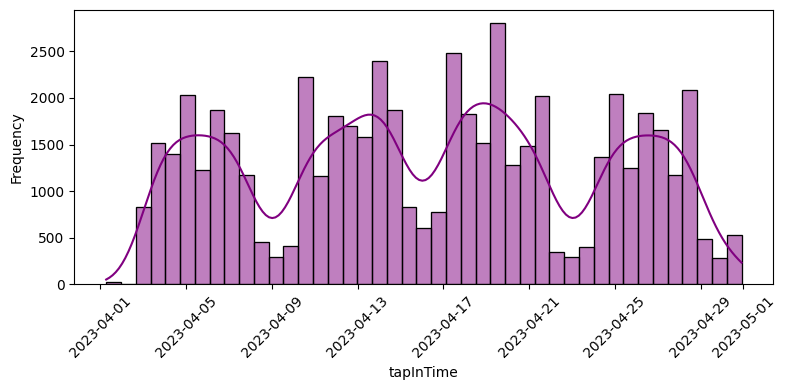

In [32]:
plt.figure(figsize=(8,4))
sns.histplot(df_tj['tapInTime'].astype('datetime64[ns]'), kde=True, stat='frequency', color='purple')
plt.xticks(rotation=45)
plt.tight_layout();

Setelah kita selesai *casting* tipe data di kolom `tapInTime` dan `tapOutTime` menjadi `datetime64[ns]`, sekarang kita coba cari `mean` dan `median` dari durasi perjalanan penumpang Transjakarta.

In [33]:
display(
    round((df_tj['tapOutTime'] - df_tj['tapInTime']).dt.total_seconds().median() / 60, 2),
    round((df_tj['tapOutTime'] - df_tj['tapInTime']).dt.total_seconds().mean() / 60, 2)
)

np.float64(71.83)

np.float64(72.13)

Meskipun perbedaannya sangat kecil antara `mean` dan `median` dari durasi perjalanan penumpang Transjakarta, kita akan gunakan `median` karena dapat lebih menyesuaikan dengan `bentuk persebaran datanya`.

In [34]:
median_dur = round((df_tj['tapOutTime'] - df_tj['tapInTime']).dt.total_seconds().median() / 60, 2)

print(f'Rata-rata durasi perjalanan penumpang: {median_dur} menit')

Rata-rata durasi perjalanan penumpang: 71.83 menit


In [35]:
df_tj['tapOutTime'] = df_tj['tapOutTime'].fillna(df_tj['tapInTime'].apply(lambda x: x + pd.Timedelta(minutes=int(median_dur))))

**Mari cek hasilnya**

In [36]:
display(tj_raw[tj_raw['tapOutTime'].isna()][col_to_validate].head(), \
        df_tj.iloc[[6,30,70,130,192]][col_to_validate])

,corridorName,direction,stopStartSeq,tapInTime,tapOutStopsLat,tapOutStopsLon,stopEndSeq,tapOutTime,payAmount
6,Kalibata - Kuningan,0.0,25,2023-04-03 06:58:21,NaN,NaN,NaN,NaT,0.0
30,Pasar Minggu - Jagakarsa,1.0,19,2023-04-03 06:14:02,NaN,NaN,NaN,NaT,0.0
70,Cibubur - Balai Kota,0.0,7,2023-04-03 05:57:55,NaN,NaN,NaN,NaT,20000.0
130,Kampung Rambutan - Tanjung...,0.0,7,2023-04-03 05:40:04,NaN,NaN,NaN,NaT,3500.0
192,Kalideres - Gelora Bung Karno,0.0,11,2023-04-03 06:15:53,NaN,NaN,NaN,NaT,3500.0


,corridorName,direction,stopStartSeq,tapInTime,tapOutStopsLat,tapOutStopsLon,stopEndSeq,tapOutTime,payAmount
6,Kalibata - Kuningan,0.0,25,2023-04-03 06:58:21,-6.223368,106.850358,31,2023-04-03 08:09:21,0.0
30,Pasar Minggu - Jagakarsa,1.0,19,2023-04-03 06:14:02,-6.291958,106.832726,26,2023-04-03 07:25:02,0.0
70,Cibubur - Balai Kota,0.0,7,2023-04-03 05:57:55,-6.207782,106.823527,15,2023-04-03 07:08:55,20000.0
130,Kampung Rambutan - Tanjung...,0.0,7,2023-04-03 05:40:04,-6.169748,106.875205,15,2023-04-03 06:51:04,3500.0
192,Kalideres - Gelora Bung Karno,0.0,11,2023-04-03 06:15:53,-6.159427,106.747950,18,2023-04-03 07:26:53,3500.0


In [37]:
# Perbandingan dengan corridorID
display(
    tj_raw.groupby(['direction','tapInStopsName','tapOutStopsName'])['corridorName'] \
        .transform(lambda x: mode_imputer.fit_transform(x.values.reshape(-1, 1)).ravel() \
        if not x.mode().empty else x).isna().sum(), # 1473
    tj_raw.groupby(['corridorID','tapInStopsName','tapOutStopsName'])['corridorName'] \
        .transform(lambda x: mode_imputer.fit_transform(x.values.reshape(-1, 1)).ravel() \
        if not x.mode().empty else x).isna().sum() # 2605
)
# Perbandingan dengan tapInStops
display(
    tj_raw.groupby(['direction','tapOutStopsName'])['tapInStopsName'] \
        .transform(lambda x: mode_imputer.fit_transform(x.values.reshape(-1, 1)).ravel() \
        if not x.mode().empty else x).isna().sum(), # 1344
    tj_raw.groupby(['tapInStops','tapOutStopsName'])['tapInStopsName'] \
        .transform(lambda x: mode_imputer.fit_transform(x.values.reshape(-1, 1)).ravel() \
        if not x.mode().empty else x).isna().sum() # 2521
)
# Perbandingan dengan tapOutStops
display(
    tj_raw.groupby(['direction','tapInStopsName'])['tapOutStopsName'] \
        .transform(lambda x: mode_imputer.fit_transform(x.values.reshape(-1, 1)).ravel() \
        if not x.mode().empty else x).isna().sum(), # 46
    tj_raw.groupby(['tapOutStops','tapInStopsName'])['tapOutStopsName'] \
        .transform(lambda x: mode_imputer.fit_transform(x.values.reshape(-1, 1)).ravel() \
        if not x.mode().empty else x).isna().sum() # 2289
)

np.int64(1473)

np.int64(2605)

np.int64(1344)

np.int64(2521)

np.int64(46)

np.int64(2289)

Tampaknya imputasi lebih efisien jika kita lakukan tanpa mengandalkan kolom `corridorID`, `tapInStops`, dan `tapOutStops`. Berarti ketiga kolom ini memang tidak relevan untuk analisa dan tidak dapat kita manfaatkan juga. Oleh karena itu mari kita *drop* ketiga kolom ini.

In [38]:
df_tj = df_tj.drop(columns=['corridorID','tapInStops','tapOutStops'], axis=1)
df_tj.columns

Index(['transID', 'payCardID', 'payCardBank', 'payCardName', 'payCardSex',
       'payCardBirthDate', 'corridorName', 'direction', 'tapInStopsName',
       'tapInStopsLat', 'tapInStopsLon', 'stopStartSeq', 'tapInTime',
       'tapOutStopsName', 'tapOutStopsLat', 'tapOutStopsLon', 'stopEndSeq',
       'tapOutTime', 'payAmount'],
      dtype='object')

Sekarang kita coba mengisi *missing values* di kolom `payAmount` yang bertipe numerik. Mari kita awali dengan melakukan *plot* agar dapat mengetahui bentuk distribusi datanya.

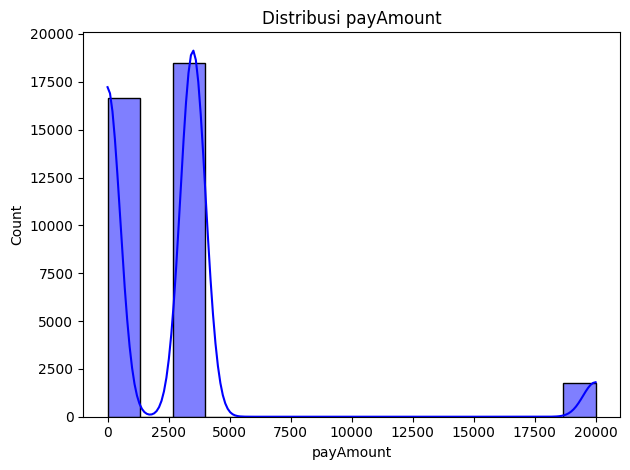

In [39]:
sns.histplot(df_tj['payAmount'], kde=True, bins=15, color='b')
plt.title('Distribusi payAmount')

plt.tight_layout();

Terlihat bahwa distribusi data pada kolom `payAmount` tidak berbentuk normal, melainkan terdiri dari beberapa nilai tetap yang berulang, yaitu Rp 0, Rp 3.500, dan Rp 20.000. Nilai Rp 3.500 merupakan tarif reguler Transjakarta, sedangkan Rp 0 kemungkinan berasal dari pengguna program subsidi (seperti ASN, atau Jaklingko).

In [40]:
display(
    df_tj[df_tj['payCardSex'] == 'M']['payAmount'].value_counts(),
    df_tj[df_tj['payCardSex'] == 'F']['payAmount'].value_counts()
)

payAmount
3500.0     8820
0.0        7624
20000.0     803
Name: count, dtype: int64

payAmount
3500.0     9683
0.0        9024
20000.0     939
Name: count, dtype: int64

Selain itu, terlihat bahwa terdapat anomali di kolom `payAmount` dengan nilai Rp 20.000, namun berdasarkan *domain knowledge*, Transjakarta memang menyediakan layanan bus premium dengan harga Rp 20.000 yang bernama [Royaltrans dan telah beroperasi sejak tahun 2017.](https://megapolitan.kompas.com/read/2023/08/27/01000061/tarif-royaltrans-dan-rutenya-2023)

Berdasarkan *domain knowledge* tersebut, kita ambil keputusan untuk **tidak merubah atau mengeliminasi** *outliers* di kolom `payAmount` karena kita justru bisa mendapatkan **insight** dengan cara menganalisa dan membandingkan 3 moda layanan Transjakarta untuk menjawab permasalahan yang telah kita rumuskan sebelumnya.

Selanjutnya, mita lanjutkan proses penanganan *missing values* untuk kolom `payAmount`.

In [41]:
df_tj[['payCardName','payCardBirthDate']].nunique()

payCardName         1993
payCardBirthDate      67
dtype: int64

Dengan distribusi yang tidak normal, kita kesampingkan imputasi berdasarkan `mean`, dan dengan kolom `payAmount` yang bertipe numerik, imputasi dengan `median` menjadi opsi yang lebih cocok untuk kita terapkan.

Kita akan lakukan `Simple Imputer` (`median`) berdasarkan kolom `payCardBirthDate` para penumpang Transjakarta. Karena terlihat dari 37900 *records*, tampaknya berasal dari `1993` orang yang memang mengandalkan layanan Transjakarta sebagai opsi utama transportasi mereka.

In [42]:
display(df_tj['payAmount'].isna().sum())
print(f'{round(df_tj['payAmount'].isna().sum() / len(df_tj) * 100, 2)}%')

np.int64(1007)

2.66%


In [43]:
display(df_tj['payAmount'].mode(), df_tj['payAmount'].median())

0    3500.0
Name: payAmount, dtype: float64

np.float64(3500.0)

In [44]:
median_imputer = SimpleImputer(strategy='median')

In [45]:
display(
df_tj.groupby('payCardBirthDate')['payAmount'] \
    .transform(lambda x: median_imputer.fit_transform(x.values.reshape(-1, 1)).ravel() if not x.mode().empty else x).value_counts(),
df_tj.groupby('payCardBirthDate')['payAmount'] \
    .transform(lambda x: median_imputer.fit_transform(x.values.reshape(-1, 1)).ravel() if not x.mode().empty else x).isna().sum()
)

payAmount
3500.0     19294
0.0        16864
20000.0     1742
Name: count, dtype: int64

np.int64(0)

In [46]:
df_tj['payAmount'] = df_tj.groupby('payCardBirthDate')['payAmount'] \
    .transform(lambda x: median_imputer.fit_transform(x.values.reshape(-1, 1)).ravel() if not x.mode().empty else x)

**Sekarang kita bandingkan dan cek hasilnya**

In [47]:
tj_raw[tj_raw['payAmount'].isna()].sample(5).index

Index([31964, 24691, 14382, 35862, 14964], dtype='int64')

In [48]:
display( # 1669, 27329, 10876, 36708, 35887
    tj_raw.loc[[1669, 27329, 10876, 36708, 35887]][col_to_validate],
    df_tj.loc[[1669, 27329, 10876, 36708, 35887]][col_to_validate]
)

,corridorName,direction,stopStartSeq,tapInTime,tapOutStopsLat,tapOutStopsLon,stopEndSeq,tapOutTime,payAmount
1669,BKN - Blok M,0.0,1,2023-04-05 17:59:10,-6.243369,106.80188,24.0,2023-04-05 19:34:26,NaN
27329,Tanjung Priok - Tanah Merdeka,1.0,10,2023-04-24 09:53:55,-6.127292,106.90605,11.0,2023-04-24 11:03:48,0.0
10876,Stasiun Tebet - Kampung Me...,0.0,1,2023-04-27 05:35:51,-6.220486,106.86825,11.0,2023-04-27 06:26:50,NaN
36708,BKN - Blok M,0.0,14,2023-04-17 18:13:35,-6.240036,106.82842,19.0,2023-04-17 19:18:09,NaN
35887,Stasiun Tebet - Rusun Kare...,0.0,10,2023-04-15 20:26:06,-6.221933,106.82093,12.0,2023-04-15 21:49:30,NaN


,corridorName,direction,stopStartSeq,tapInTime,tapOutStopsLat,tapOutStopsLon,stopEndSeq,tapOutTime,payAmount
1669,BKN - Blok M,0.0,1,2023-04-05 17:59:10,-6.243369,106.80188,24,2023-04-05 19:34:26,3500.0
27329,Tanjung Priok - Tanah Merdeka,1.0,10,2023-04-24 09:53:55,-6.127292,106.90605,11,2023-04-24 11:03:48,0.0
10876,Stasiun Tebet - Kampung Me...,0.0,1,2023-04-27 05:35:51,-6.220486,106.86825,11,2023-04-27 06:26:50,3500.0
36708,BKN - Blok M,0.0,14,2023-04-17 18:13:35,-6.240036,106.82842,19,2023-04-17 19:18:09,3500.0
35887,Stasiun Tebet - Rusun Kare...,0.0,10,2023-04-15 20:26:06,-6.221933,106.82093,12,2023-04-15 21:49:30,0.0


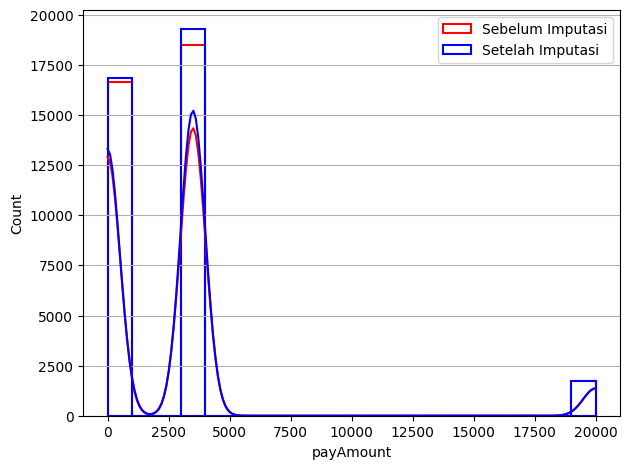

In [49]:
sns.histplot(tj_raw['payAmount'], kde=True, color='red', bins=20, fill=False, label='Sebelum Imputasi')
sns.histplot(df_tj['payAmount'], kde=True, color='blue', bins=20, fill=False, label='Setelah Imputasi')
plt.legend()
plt.grid(axis='y')

plt.tight_layout()

Hasil imputasi pada kolom `payAmount` tidak mengakibatkan perubahan pada distribusi data, dan perbedaan yang ada juga masih bisa kita toleransi.

#### **DF Cleaned**

Sekarang kita `drop` **Null** yang tersisa, dan mari kita bandingkan hasil total entries dataset kita sesudah dan sebelum kita melakukan cleansing.

In [50]:
display(df_tj.columns, df_tj.isna().sum())

Index(['transID', 'payCardID', 'payCardBank', 'payCardName', 'payCardSex',
       'payCardBirthDate', 'corridorName', 'direction', 'tapInStopsName',
       'tapInStopsLat', 'tapInStopsLon', 'stopStartSeq', 'tapInTime',
       'tapOutStopsName', 'tapOutStopsLat', 'tapOutStopsLon', 'stopEndSeq',
       'tapOutTime', 'payAmount'],
      dtype='object')

transID               0
payCardID             0
payCardBank           0
payCardName           0
payCardSex            0
payCardBirthDate      0
corridorName        174
direction             0
tapInStopsName        0
tapInStopsLat         0
tapInStopsLon         0
stopStartSeq          0
tapInTime             0
tapOutStopsName      46
tapOutStopsLat        0
tapOutStopsLon        0
stopEndSeq            0
tapOutTime            0
payAmount             0
dtype: int64

In [51]:
df_tj.loc[:,df_tj.isna().sum() > 0].columns

Index(['corridorName', 'tapOutStopsName'], dtype='object')

In [52]:
df_tj_missing = pd.DataFrame(df_tj[['corridorName','tapOutStopsName']].isna().sum()).rename(columns={0:'missingCount'})
df_tj_missing['missingPercentage'] = round((df_tj_missing['missingCount'] / len(df_tj)), 4) * 100
df_tj_missing

,missingCount,missingPercentage
corridorName,174,0.46
tapOutStopsName,46,0.12


Setelah kita selsai mencoba `SimpleImputer` dan `IterativeImputer`, kini *missing values* dataset kita hanya memiliki *missing values* dengan persentase dibawah 1%. Oleh karena itu, kita bisa gunakan `dropna()` sebagai opsi terakhir.

In [53]:
df = df_tj.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 37726 entries, 0 to 37899
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   transID           37726 non-null  object        
 1   payCardID         37726 non-null  int64         
 2   payCardBank       37726 non-null  object        
 3   payCardName       37726 non-null  object        
 4   payCardSex        37726 non-null  object        
 5   payCardBirthDate  37726 non-null  int64         
 6   corridorName      37726 non-null  object        
 7   direction         37726 non-null  float64       
 8   tapInStopsName    37726 non-null  object        
 9   tapInStopsLat     37726 non-null  float64       
 10  tapInStopsLon     37726 non-null  float64       
 11  stopStartSeq      37726 non-null  int64         
 12  tapInTime         37726 non-null  datetime64[ns]
 13  tapOutStopsName   37726 non-null  object        
 14  tapOutStopsLat    37726 non

<Axes: >

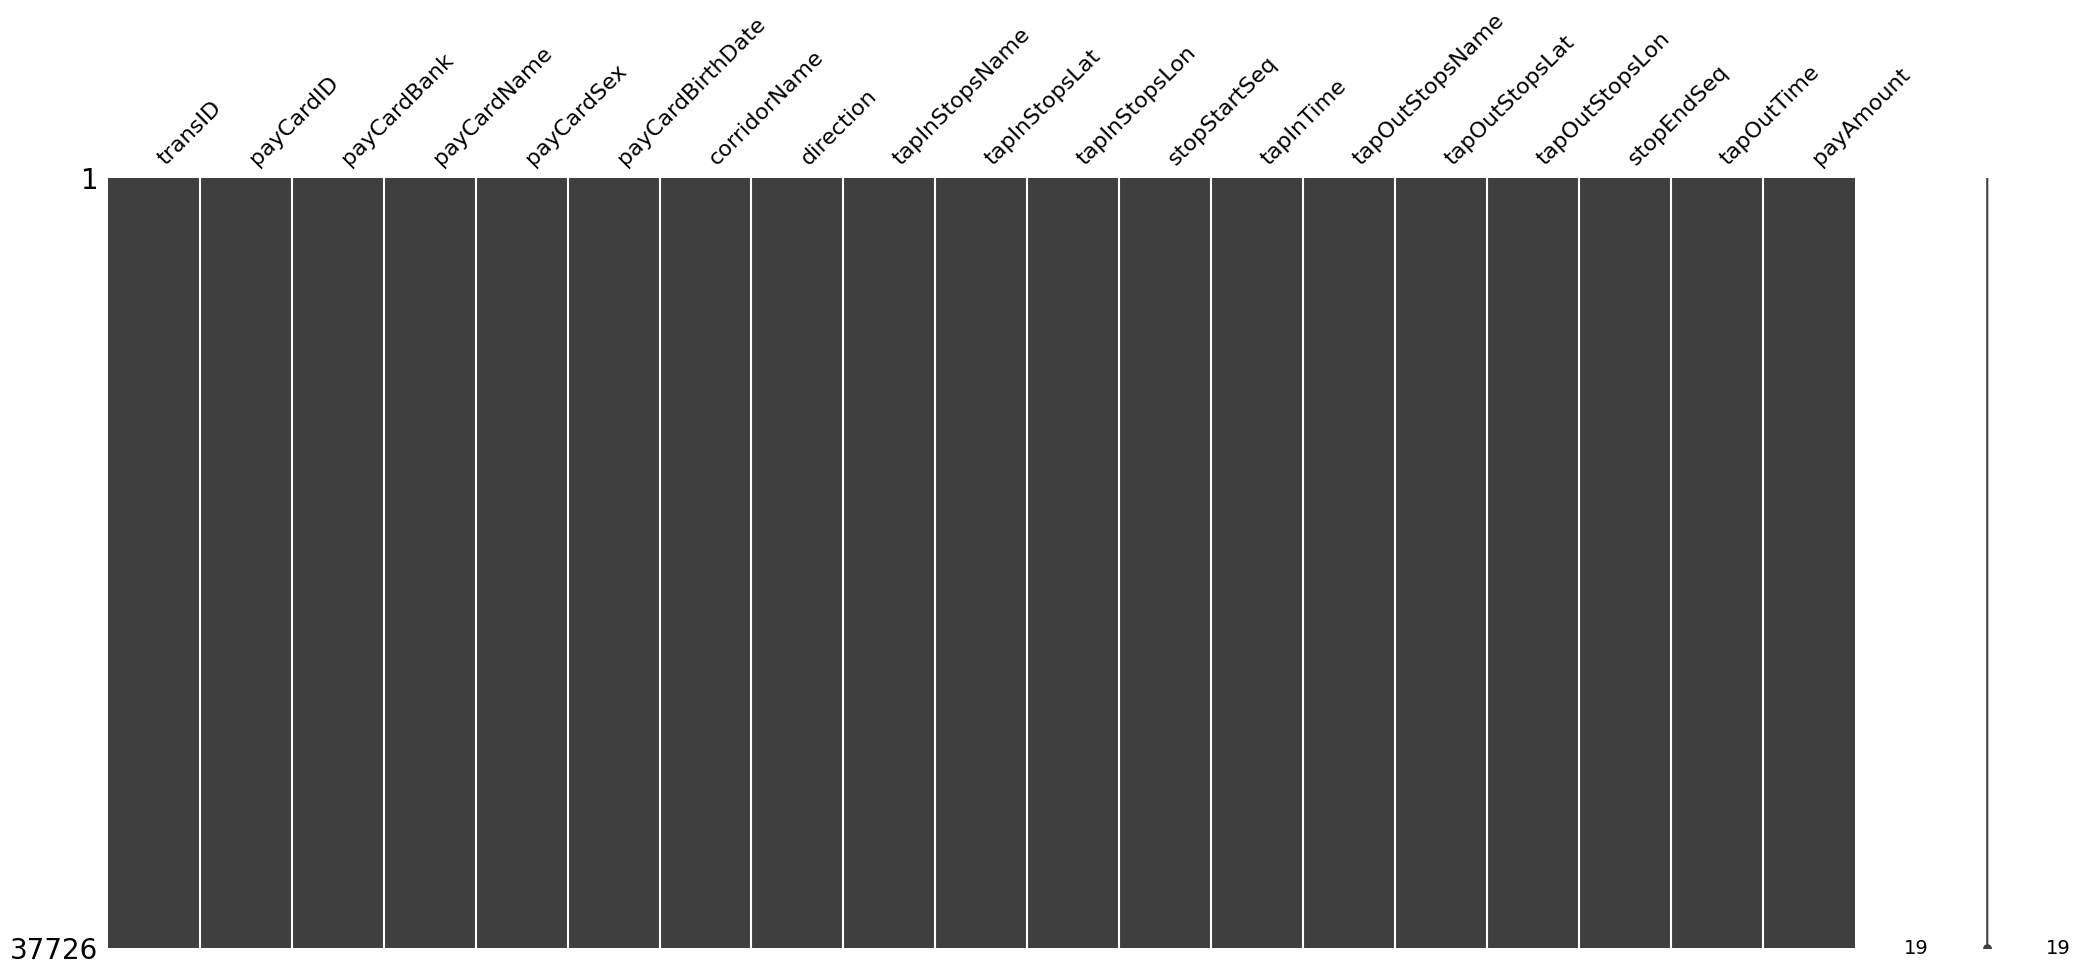

In [54]:
msno.matrix(df)

In [55]:
pd.set_option('display.max_colwidth', 60)
unique_items = []

for col in df.columns :
    unique_items.append( [col, df[col].nunique(), df[col].unique()])

raw_desc = pd.DataFrame(columns=['Column Name', 'Number of Unique', 'Unique Sample'],
                     data=unique_items)
raw_desc

,Column Name,Number of Unique,Unique Sample
0,transID,37726,"[EIIW227B8L34VB, LGXO740D2N47GZ, DJWR385V2U57TO, JTUZ800..."
1,payCardID,1982,"[180062659848800, 4885331907664776, 4996225095064169, 63..."
2,payCardBank,6,"[emoney, dki, flazz, online, brizzi, bni]"
3,payCardName,1975,"[Bajragin Usada, Gandi Widodo, Emong Wastuti, Surya Waca..."
4,payCardSex,2,"[M, F]"
5,payCardBirthDate,67,"[2008, 1997, 1992, 1978, 1982, 1993, 1974, 1991, 2004, 1..."
6,corridorName,216,"[Matraman Baru - Ancol, Stasiun Tebet - Karet via Patra ..."
7,direction,2,"[1.0, 0.0]"
8,tapInStopsName,2515,"[Pal Putih, Kemenkes 2, Gg. Kunir II, Taman Elok 1, Sunt..."
9,tapInStopsLat,2500,"[-6.184631, -6.2287, -6.133132, -6.195743, -6.14965, -6...."


In [56]:
df.isna().sum().sum()

np.int64(0)

Kita telah menyelesaikan proses *data cleansing* dan mari kita simpan hasil dataset yang sudah bersih menjadi file bernama `tj_cleaned.csv`


In [57]:
# df.to_csv('D:/Bonifasius/Capstone Project (Data Analysis)/cleaned_dataset/tj_cleaned.csv', index=False)

Kita telah pastikan tidak ada *record* yang duplikat dan terdapat *missing values*. Untuk proses analisis, kita juga tidak membutuhkan ID unik dari kolom `transID` dan `payCardID` karena tidak relevan, maka 2 kolom ini dapat kita `drop` saja.

In [58]:
df = df.iloc[:,2:]

In [59]:
display(df.shape, df.sample(5))

(37726, 17)

,payCardBank,payCardName,payCardSex,payCardBirthDate,corridorName,direction,tapInStopsName,tapInStopsLat,tapInStopsLon,stopStartSeq,tapInTime,tapOutStopsName,tapOutStopsLat,tapOutStopsLon,stopEndSeq,tapOutTime,payAmount
28984,bni,"Rafi Lestari, S.I.Kom",F,1985,PGC 2 - Tanjung Priok,1.0,Tanjung Priok,-6.109590,106.88214,0,2023-04-25 19:50:56,Pedati Prumpung,-6.220160,106.87439,15,2023-04-25 20:41:42,3500.0
12290,dki,"Simon Utama, S.Psi",F,1987,TU Gas - Bundaran Senayan,0.0,Sunan Giri,-6.193267,106.88367,4,2023-04-03 08:54:23,Karet Sudirman,-6.212457,106.82003,22,2023-04-03 09:46:59,3500.0
28771,emoney,Dagel Ardianto,M,1973,Kampung Rambutan - Pinang Ranti,0.0,SDN Dukuh 01,-6.287794,106.87406,18,2023-04-25 21:39:28,Garuda Taman Mini 2,-6.290148,106.88162,20,2023-04-25 23:15:16,0.0
14327,bni,"Tgk. Farhunnisa Pertiwi, S.Farm",M,1999,Ciputat - CSW,1.0,Kejaksaan Agung,-6.240500,106.79844,0,2023-04-05 09:58:25,Jln. H. Ahmad,-6.262573,106.78857,11,2023-04-05 10:59:07,3500.0
26964,emoney,Yuni Yulianti,F,1990,Stasiun Tebet - Rusun Karet Tengsin,0.0,Viva Futsal,-6.218724,106.81944,13,2023-04-21 17:52:41,PU Irigasi,-6.201479,106.81079,20,2023-04-21 19:02:42,3500.0


In [60]:
print(f'Jumlah total entries sebelum proses cleansing = {len(tj_raw)}\n')
print(f'Jumlah total entries setelah proses cleansing = {len(df)}\n')
print(f'Persentase entries setelah proses cleansing = {round(len(df) / len(tj_raw) * 100, 2)}%')

Jumlah total entries sebelum proses cleansing = 37900

Jumlah total entries setelah proses cleansing = 37726

Persentase entries setelah proses cleansing = 99.54%


#### **Handle Outlier**

Selanjutnya, mari kita tindak lanjuti anomali seperti nilai `outlier` yang terdapat di dataset TransJakarta. Di bagian *inspeksi dataset* kita telah mengetahui terdapat anomali di kolom `payAmount` dan juga `durasi perjalanan penumpang`. 

Mempertimbangkan keputusan yang telah kita ambil berdasarkan *domain knowledge* terkait anomali di kolom `payAmount`, sekarang kita akan coba investigasi lebih lanjut untuk anomali di `durasi perjalanan`.

Sekarang kita buat kolom baru bernama `hours` dengan meng-ekstrak dari kolom `tapInTime` dan satu kolom baru lagi yaitu `travelTimeMnts` untuk mencari `durasi perjalanan` dari setiap penumpang dalam `satuan menit`.

In [61]:
df['travelTimeMnts'] = round((df['tapOutTime'] - df['tapInTime']).dt.total_seconds() / 60, 2)
df['hours'] = df['tapInTime'].dt.hour

display(df['travelTimeMnts'].sample(2), df['hours'].sample(2), df.sample(3))

24461    93.53
9640     71.00
Name: travelTimeMnts, dtype: float64

6610     5
23313    6
Name: hours, dtype: int32

,payCardBank,payCardName,payCardSex,payCardBirthDate,corridorName,direction,tapInStopsName,tapInStopsLat,tapInStopsLon,stopStartSeq,tapInTime,tapOutStopsName,tapOutStopsLat,tapOutStopsLon,stopEndSeq,tapOutTime,payAmount,travelTimeMnts,hours
6462,online,"Cahyono Firmansyah, S.Pd",M,1992,PGC 2 - Tanjung Priok,0.0,Penas Kalimalang,-6.239070,106.87800,4,2023-04-17 17:28:06,Cempaka Mas,-6.165888,106.879200,14,2023-04-17 19:27:55,3500.0,119.82,17
2274,online,Balapati Gunarto,M,1977,Rusun Tambora - Pluit,1.0,Jembatan Dua,-6.143279,106.79352,3,2023-04-06 16:56:13,Rusun Tambora,-6.147327,106.798676,4,2023-04-06 18:05:41,0.0,69.47,16
4236,flazz,Margana Narpati,F,1989,Monas - Pantai Indah Kapuk,1.0,Monas 2,-6.175999,106.82311,7,2023-04-12 05:12:31,Monas 3,-6.178787,106.823040,8,2023-04-12 05:40:34,0.0,28.05,5


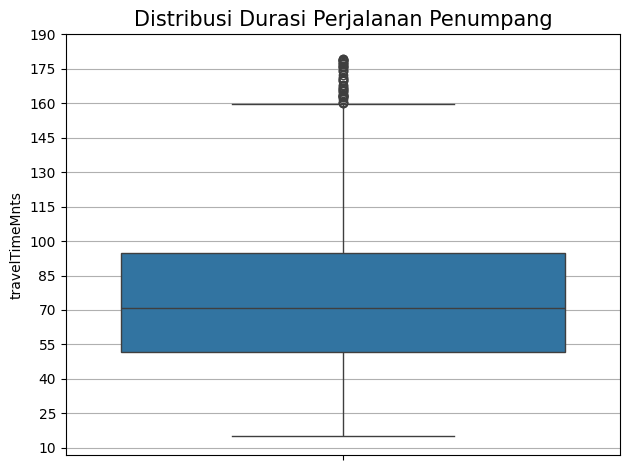

In [62]:
sns.boxplot(df['travelTimeMnts'])
plt.yticks(range(10,195,15))
plt.grid(axis='y')
plt.title('Distribusi Durasi Perjalanan Penumpang', size=15)

plt.tight_layout();

Kita coba definisikan `outlier` di kolom `travelTimeMnts` dengan mencari `IQR` dari kolom tersebut.

In [63]:
Q1 = df['travelTimeMnts'].quantile(0.25)
Q3 = df['travelTimeMnts'].quantile(0.75)
IQR = Q3 - Q1
batas_bawah = Q1 - 1.5 * IQR
batas_atas = Q3 + 1.5 * IQR

outliers = df[(df['travelTimeMnts'] < batas_bawah) | (df['travelTimeMnts'] > batas_atas)]

In [64]:
display(
    len(index_anomali_waktu),
    len(outliers),
    outliers.sample(3)
)

44

43

,payCardBank,payCardName,payCardSex,payCardBirthDate,corridorName,direction,tapInStopsName,tapInStopsLat,tapInStopsLon,stopStartSeq,tapInTime,tapOutStopsName,tapOutStopsLat,tapOutStopsLon,stopEndSeq,tapOutTime,payAmount,travelTimeMnts,hours
37861,dki,Farah Latupono,M,2010,Tanah Abang - St. Gondangdia,0.0,Jln. Kb. Kacang VIII,-6.187181,106.81827,8,2023-04-30 15:52:34,Pospol Jati Bunder,-6.189707,106.81317,15,2023-04-30 18:38:25,3500.0,165.85,15
37614,dki,"Tgk. Hesti Situmorang, M.TI.",F,1996,Cililitan - Kp. Pulo,0.0,Dinas Lingkungan Hidup,-6.264168,106.87033,17,2023-04-29 08:33:17,Sbr. Kec. Makasar,-6.279335,106.87881,29,2023-04-29 11:30:27,0.0,177.17,8
37761,dki,Olivia Irawan,M,1984,Stasiun Palmerah - Bundaran Senayan,1.0,Manggala Wanabakti,-6.204951,106.79963,5,2023-04-08 05:36:09,St. Palmerah,-6.208908,106.79706,6,2023-04-08 08:16:20,3500.0,160.18,5


Berdasarkan `IQR`, ditemukan `43 outlier` perjalanan dengan durasi di atas `160 menit`. *Records* ini kita `drop` saja dari dataset karena dianggap tidak merepresentasikan durasi perjalanan wajar TransJakarta dan berpotensi disebabkan oleh kesalahan pencatatan sistem.

In [65]:
df = df.drop(index = outliers.index)
df.shape

(37683, 19)

## **Data Analysis**

Akhirnya, kita sekarang dapat memulai proses analisis terhadap dataset TransJakarta yang sudah kita persiapkan.

Karena sebelumnya kita sudah menambahkan kolom `travelTimeMnts` untuk durasi perjalanan, kemudian mari tambahkan kolom baru yaitu `age` agar kita dapat melihat demografi penumpang TransJakarta berdasarkan `gender` dan juga `usia`.

In [66]:
df['age'] = (2023 - df['payCardBirthDate']).astype(int)

### **Berdasarkan Arah Tujuan Penumpang TransJakarta**

1. Bagaimana distribusi data durasi perjalanan penumpang TransJakarta?
1. Apakah terdapat perbedaan durasi perjalanan antara penumpang arah `pergi` dan `pulang`?

Mari kita uji normalitas kolom `travelTimeMnts`.

In [67]:
from scipy.stats import kstest

stats, pval = kstest(df['travelTimeMnts'], 'norm')
if pval <= 0.05:
    print('Distribusi tidak normal') #Ha
else:
    print('Distribusi Normal') #Ho

Distribusi tidak normal


Kita akan melakukan uji banding rata-rata non-parametrik karena distribusi datanya tidak normal. Oleh karena itu, kita gunakan `Mann Whitney` untuk membandingkan arah pergi dan pulang. 

In [68]:
from scipy.stats import mannwhitneyu

h0 = 'Tidak terdapat perbedaan rata-rata durasi perjalanan antara penumpang yang arah pergi dengan yang arah pulang.'
ha = 'Terdapat perbedaan rata-rata durasi perjalanan yang signifikan antara penumpang yang arah pergi dengan yang arah pulang.'

pergi = df[df['direction'] == 0]['travelTimeMnts']
pulang = df[df['direction'] == 1]['travelTimeMnts']

stat, pval = mannwhitneyu(pergi, pulang, alternative='two-sided')

print(f'U-Statistic: {stat}, p-value: {pval}')

if pval <= 0.05:
    print('Tolak H0')
    print(ha)
else:
    print('Gagal menolak H0')
    print(h0)

U-Statistic: 169445135.5, p-value: 2.34884116312256e-14
Tolak H0
Terdapat perbedaan rata-rata durasi perjalanan yang signifikan antara penumpang yang arah pergi dengan yang arah pulang.


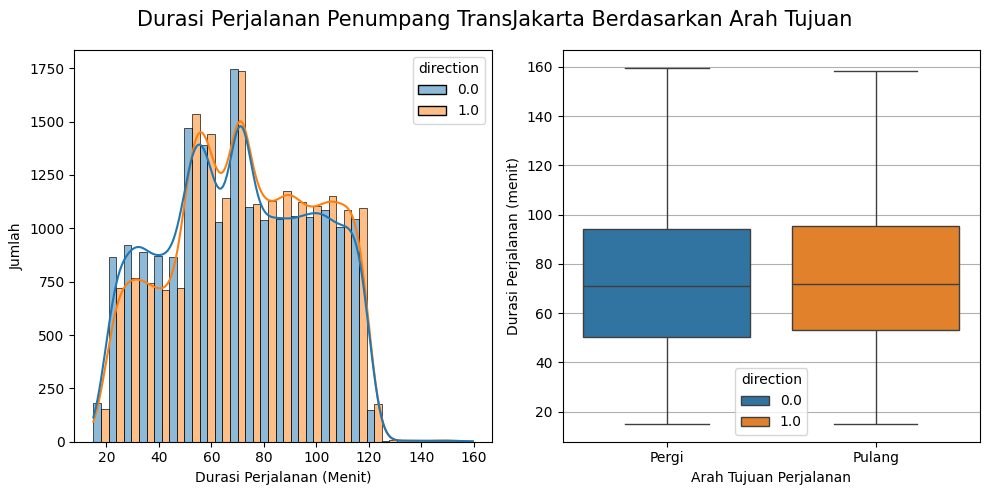

In [69]:
fig, ax = plt.subplots(1,2, figsize=(10,5))

sns.histplot(df, x='travelTimeMnts', kde=True, hue='direction', bins=25, multiple='dodge', ax=ax[0])
ax[0].set_xlabel('Durasi Perjalanan (Menit)')
ax[0].set_ylabel('Jumlah')

sns.boxplot(data=df, x='direction', y='travelTimeMnts', hue='direction', ax=ax[1])
ax[1].set_xticks([0, 1], ['Pergi','Pulang'])
ax[1].set_ylabel('Durasi Perjalanan (menit)')
ax[1].set_xlabel('Arah Tujuan Perjalanan')
ax[1].grid(axis='y')

fig.suptitle('Durasi Perjalanan Penumpang TransJakarta Berdasarkan Arah Tujuan', fontsize=15)

plt.tight_layout();

In [70]:
display(
  df[df['direction'] == 0.0].groupby('direction')['hours'].mean(),
  df[df['direction'] == 1.0].groupby('direction')['hours'].mean()
)

direction
0.0    11.908903
Name: hours, dtype: float64

direction
1.0    13.124748
Name: hours, dtype: float64

Dari hasil eksplorasi:

* Penumpang arah berangkat memiliki durasi perjalanan yang berbeda secara signifikan dibandingkan arah kembali, berdasarkan uji statistik Mann–Whitney U (p < 0.05).

Distribusi waktu perjalanan juga berbeda:

* Rata-rata waktu tap-in arah berangkat terjadi lebih pagi

* Arah kembali cenderung lebih sore/malam

### **Berdasarkan Rute TransJakarta**

1. Berapa nilai `mean` dan `median` dari durasi perjalanan TransJakarta?
1. Apa rute dengan durasi perjalanan tertinggi?
1. Apa rute dengan jumlah penumpang paling padat?

In [71]:
print(f'Berikut adalah rangkuman statistik untuk kolom travelTimeMnts:')
df['travelTimeMnts'].agg(['mean','median','min','max'])

Berikut adalah rangkuman statistik untuk kolom travelTimeMnts:


mean       71.967046
median     71.000000
min        15.000000
max       159.630000
Name: travelTimeMnts, dtype: float64

In [72]:
rute_terlama = pd.DataFrame(df.groupby('corridorName')['travelTimeMnts'] \
               .mean().sort_values(ascending=False).head(10)).reset_index()
rute_terlama

,corridorName,travelTimeMnts
0,Kampung Rambutan - Blok M,84.985294
1,Cinere - Kuningan,81.472614
2,Stasiun Palmerah - Tosari,81.250872
3,Senen - Pulo Gadung via Kelapa Gading,79.859307
4,Rawamangun - Klender,79.730408
5,Pinang Ranti - Bundaran Senayan,79.539267
6,Tanah Abang - Kebayoran Lama via Pos Pengumben,79.314583
7,Puri Kembangan - Sentraland Cengkareng,78.678523
8,Grogol - Pos Pengumben via Slipi,78.645476
9,Term. Pulo Gadung - Lampiri,78.501290


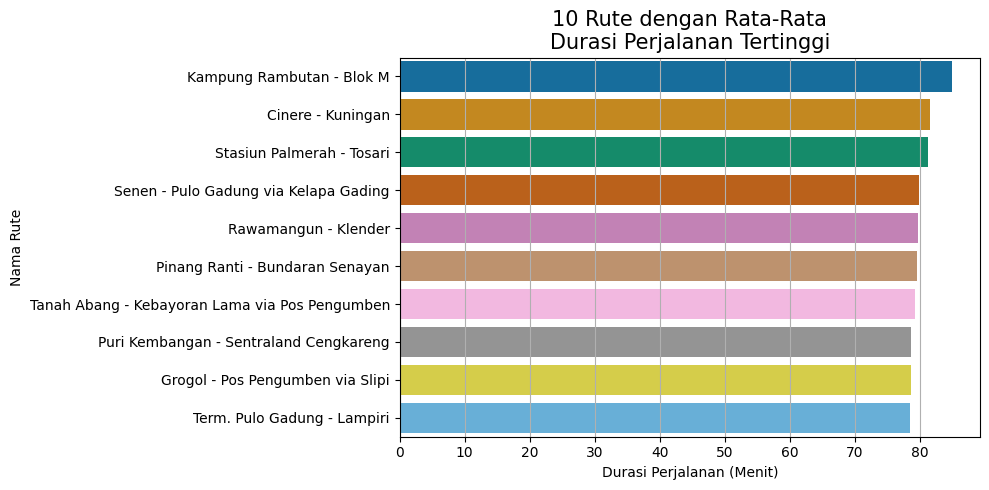

In [73]:
plt.figure(figsize=(10,5))
sns.barplot(rute_terlama, y='corridorName', x='travelTimeMnts', palette='colorblind')
plt.title('10 Rute dengan Rata-Rata\nDurasi Perjalanan Tertinggi', size=15)
plt.xlabel('Durasi Perjalanan (Menit)')
plt.ylabel('Nama Rute')
plt.grid(axis='x')

plt.tight_layout();

Sebuah temuan yang menarik karena 3 peringkat teratas dari rute dengan rata-rata durasi perjalanan tertinggi semuanya berada di ruas jalan area `Jakarta Selatan`:
* Kampung Rambutan - Blok M
* Cinere - Kuningan
* Stasiun Palmerah - Tosari

Masuk akal karena area Jakarta Selatan didominasi oleh **pusat bisnis dan perkantoran**, sehingga:
* Lalu lintas lebih padat, terutama pada jam sibuk
* Durasi perjalanan cenderung lebih lama

Mengacu kepada [Google Maps direction](https://maps.app.goo.gl/W4R4qDaF7wd2Xqyv6), durasi perjalanan yang dibutuhkan untuk rute `Kampung Rambutan - Blok M yaitu sekitar 35-45 menit untuk kendaraan roda 2 maupun roda 4`. Perbedaan durasi perjalanan antara menggunakan kendaraan pribadi dengan layanan Transjakarta, memang menjadi sebuah pertimbangan yang membuat masih banyak masyarakat yang lebih memilih untuk tetap menggunakan kendaraan pribadi untuk pilihan transportasi mereka sehari-hari.

In [74]:
rute_terpadat = pd.DataFrame(df['corridorName'] \
                .value_counts().sort_values(ascending=False).head(10)).reset_index()
rute_terpadat

,corridorName,count
0,Cibubur - Balai Kota,409
1,Ciputat - CSW,395
2,Pulo Gadung - Monas,356
3,Harmoni - Jakarta International Stadium,352
4,Kalideres - Bundaran HI via Veteran,348
5,Kebayoran Lama - Tanah Abang,346
6,Kampung Rambutan - Pondok Gede,343
7,Rusun Pondok Bambu - Walikota Jakarta Timur,338
8,Pasar Minggu - Tanah Abang,327
9,Rusun Rawa Bebek - Kodamar,322


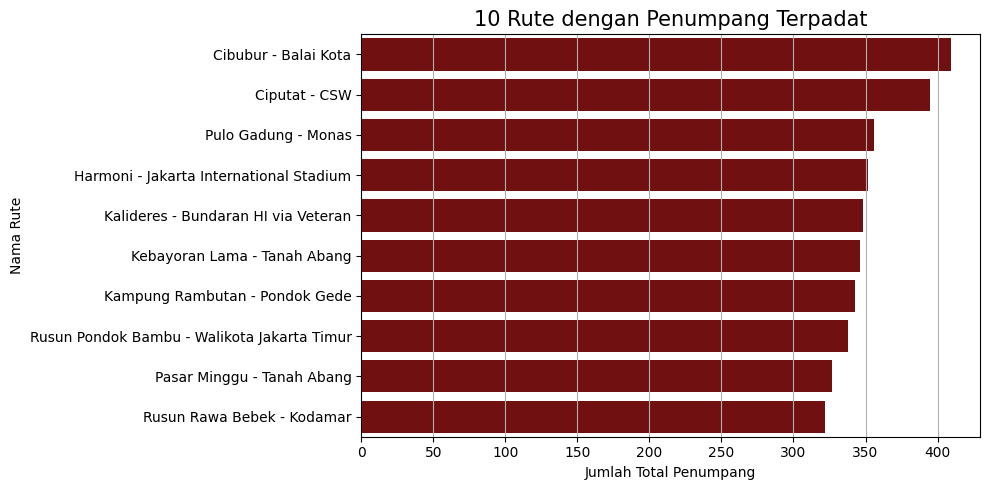

In [75]:
plt.figure(figsize=(10,5))
sns.barplot(rute_terpadat, y='corridorName', x='count', color='maroon')
plt.title('10 Rute dengan Penumpang Terpadat', size=15)
plt.xlabel('Jumlah Total Penumpang')
plt.ylabel('Nama Rute')
plt.grid(axis='x')

plt.tight_layout();

In [76]:
rute_kritis = df.groupby('corridorName').agg({
    'travelTimeMnts': 'mean',
    'payCardName': 'count'
}).rename(columns={'travelTimeMnts': 'avg_durasi', 'payCardName': 'total_penumpang'}).reset_index()

rute_kritis['rank'] = rute_kritis['avg_durasi'].rank(ascending=False) + rute_kritis['total_penumpang'].rank(ascending=False)
rute_kritis = rute_kritis.sort_values('rank', ascending=True).head(10)
rute_kritis

,corridorName,avg_durasi,total_penumpang,rank
30,Cilincing - Rorotan,77.725868,288,34.0
39,Gondangdia - Senen,77.604281,278,37.0
33,Ciputat - CSW,75.851949,395,38.0
71,Kampung Rambutan - Pasar Rebo via Poncol,76.700809,309,40.0
185,TU Gas - Bundaran Senayan,78.233793,232,55.0
129,Puri Beta 2 - Tendean,76.873043,253,56.5
142,Roxy - Benhil,76.295160,250,68.0
78,Kelapa Gading - Rusun Kemayoran,78.350233,215,71.0
203,Tanjung Priok - Sukapura,75.778725,251,73.0
108,Pinang Ranti - Pluit,77.234818,220,74.0


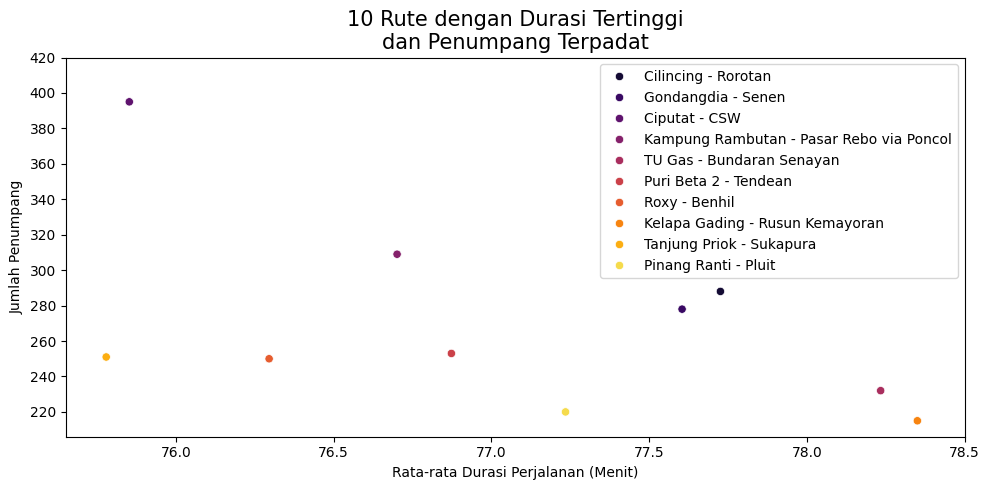

In [77]:
plt.figure(figsize=(10,5))
sns.scatterplot(rute_kritis, x='avg_durasi', y='total_penumpang', hue='corridorName', legend='brief', palette='inferno')
plt.legend(loc='upper right')
plt.xticks([76,76.5,77,77.5,78,78.5])
plt.yticks(range(220,425,20))
plt.title('10 Rute dengan Durasi Tertinggi\ndan Penumpang Terpadat', size=15)
plt.ylabel('Jumlah Penumpang')
plt.xlabel('Rata-rata Durasi Perjalanan (Menit)')

plt.tight_layout();

Dari visualisasi di atas kita dapat memahami bahwa:

- Durasi yang tinggi berpotensi pada **keterlambatan layanan TransJakarta** dan kelelahan penumpang
- Kepadatan penumpang yang berpotensi **penumpang yang menumpuk di halte/bus** dan menurunkan kenyamanan
- **Diperlukannya analisis lanjutan** terhadap penyebab utama lamanya durasi perjalanan: kemacetan, banyaknya halte, atau pergantian koridor.

###  **Berdasarkan Tarif / Moda Transportasi TransJakarta**

In [78]:
tarif = pd.DataFrame(round(df.groupby('payAmount')['travelTimeMnts'].mean(), 2).reset_index())
tarif

,payAmount,travelTimeMnts
0,0.0,72.26
1,3500.0,71.53
2,20000.0,73.98


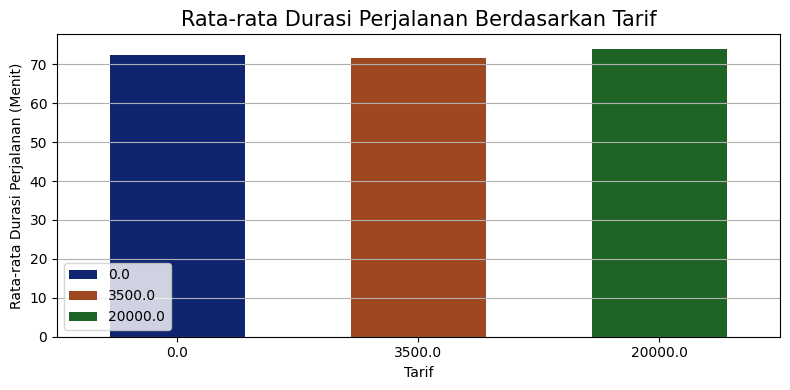

In [79]:
plt.figure(figsize=(8,4))
sns.barplot(data=tarif, x='payAmount', y='travelTimeMnts', hue='payAmount', palette='dark', legend='full', width=0.56)
plt.title('Rata-rata Durasi Perjalanan Berdasarkan Tarif', size=15)
plt.xlabel('Tarif')
plt.ylabel('Rata-rata Durasi Perjalanan (Menit)')
plt.legend(loc='lower left')
plt.grid(axis='y')

plt.tight_layout();

Dari sini terlihat bahwa layanan *RoyalTrans* tampaknya membutuhkan perbaikan dari segi efektivitas durasi perjalanan. Karena dari 3 moda transportasi, *RoyalTrans* sebagai layanan premium TransJakarta justru memiliki rata-rata durasi perjalanan tertinggi diantara ketiganya.

###  **Berdasarkan Rentang Waktu Tertentu (Jam Sibuk)**

1. Berapa lama rata-rata durasi perjalanan TransJakarta untuk setiap jam?
1. Apakah terpadat perbedaan durasi perjalanan saat jam biasa dengan jam sibuk?
1. Kapan durasi perjalanan tertinggi terjadi?

In [80]:
rush_hour = pd.crosstab(df['travelTimeMnts'],df['hours'])
rush_hour['Total'] = rush_hour.sum(axis=1)
rush_hour = rush_hour.sort_values('Total',ascending=False).head(10)
rush_hour

hours,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,Total
travelTimeMnts,,,,,,,,,,,,,,,,,,
71.00,115,213,111,93,88,8,5,5,5,7,12,118,200,93,86,76,65,1300
54.02,2,3,1,0,0,0,0,1,0,0,0,2,3,1,2,3,0,18
76.75,1,3,1,1,1,0,0,0,0,0,1,5,1,0,1,2,1,18
54.82,1,4,0,0,2,0,0,0,0,0,0,2,3,1,2,1,1,17
59.75,3,2,3,1,0,1,0,0,1,0,0,1,3,0,2,0,0,17
56.20,5,3,2,2,0,0,0,0,1,0,0,0,4,0,0,0,0,17
52.05,1,3,0,4,0,0,0,0,0,0,0,0,4,1,0,2,2,17
57.72,5,4,0,0,0,0,1,0,0,0,0,0,4,0,1,0,2,17
55.23,0,2,1,1,0,0,0,0,0,0,0,2,4,0,3,2,1,16


Tampaknya durasi perjalanan tertinggi `(71 menit)` memang benar terjadi di jam sibuk (*rush hour*) yang terjadi pada rentang waktu **jam 5-9 pagi**, kemudian **jam 4 sore-9 malam**. Kita coba visualisasikan dengan `line chart` agar dapat melihat durasi perjalanan Transjakarta.

In [81]:
top_10_rush_hour = pd.DataFrame(df.groupby('hours')['travelTimeMnts'].mean().sort_values())
top_10_rush_hour.tail(10)

,travelTimeMnts
hours,
13,69.839142
9,70.242632
8,70.797814
15,79.325128
19,82.978795
21,83.121864
18,83.280144
17,83.375155
20,83.380225


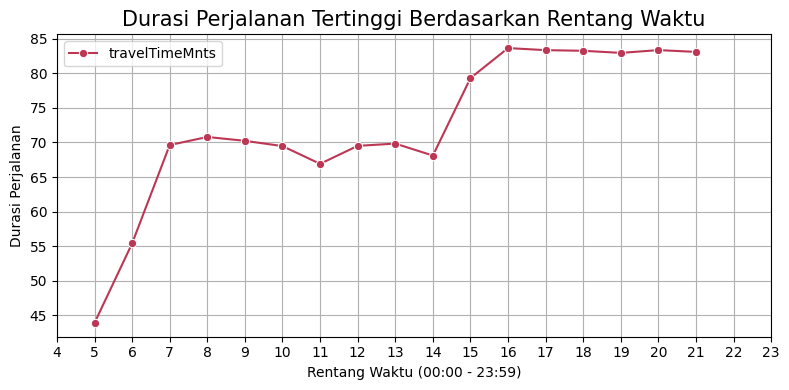

In [82]:
plt.figure(figsize=(8,4))
sns.lineplot(top_10_rush_hour, markers='o', palette='inferno')
plt.xticks(range(4,24))
plt.xlabel('Rentang Waktu (00:00 - 23:59)')
plt.ylabel('Durasi Perjalanan')
plt.title('Durasi Perjalanan Tertinggi Berdasarkan Rentang Waktu', size=15)
plt.grid()

plt.tight_layout();

Lonjakan pertama terjadi mulai dari jam `setengah 7 pagi`, masuk akal karena pada rentang waktu ini masyarakat mulai beraktivitas seperti pergi kerja, kemudian mencapai *peak rush hour* mulai dari `jam 4 sore sampai 9 malam` (saat banyak penumpang dan warga Jakarta sedang pulang dari kantor atau kegiatan lainnya)

**Pada jam-jam sibuk tersebut, rata-rata durasi perjalanan mencapai 82–83 menit, jauh lebih tinggi dibandingkan jam-jam lainnya.**

### **Berdasarkan Hari *(Weekday / Weekend)***

1. Bagaimana durasi perjalanan TransJakarta untuk setiap harinya?

In [83]:
df['days'] = df['tapInTime'].dt.day_of_week # Senin = 0

In [84]:
df.sample(2)

,payCardBank,payCardName,payCardSex,payCardBirthDate,corridorName,direction,tapInStopsName,tapInStopsLat,tapInStopsLon,stopStartSeq,tapInTime,tapOutStopsName,tapOutStopsLat,tapOutStopsLon,stopEndSeq,tapOutTime,payAmount,travelTimeMnts,hours,age,days
35858,dki,Ir. Bala Prakasa,M,1985,Joglo - Blok M,0.0,Permata Eksekutif 1,-6.216906,106.765410,22,2023-04-15 16:54:06,Jln. Taman Alfa Indah,-6.216536,106.77258,29,2023-04-15 18:05:06,3500.0,71.00,16,38,5
14558,brizzi,Lasmanto Marpaung,M,1982,Puri Beta - Kuningan (Express),1.0,Departemen Kesehatan,-6.228794,106.833205,5,2023-04-05 19:51:32,Puri Beta 2,-6.230532,106.72371,11,2023-04-05 21:04:57,3500.0,73.42,19,41,2


In [85]:
full = pd.DataFrame(df.groupby('days')['travelTimeMnts'].mean())
weekdays = pd.DataFrame(df.groupby('days')['travelTimeMnts'].mean()).iloc[:-2]
weekends = pd.DataFrame(df.groupby('days')['travelTimeMnts'].mean()).iloc[5:]
full

,travelTimeMnts
days,
0,72.010218
1,71.750862
2,72.447097
3,72.220032
4,72.273296
5,69.614776
6,70.944047


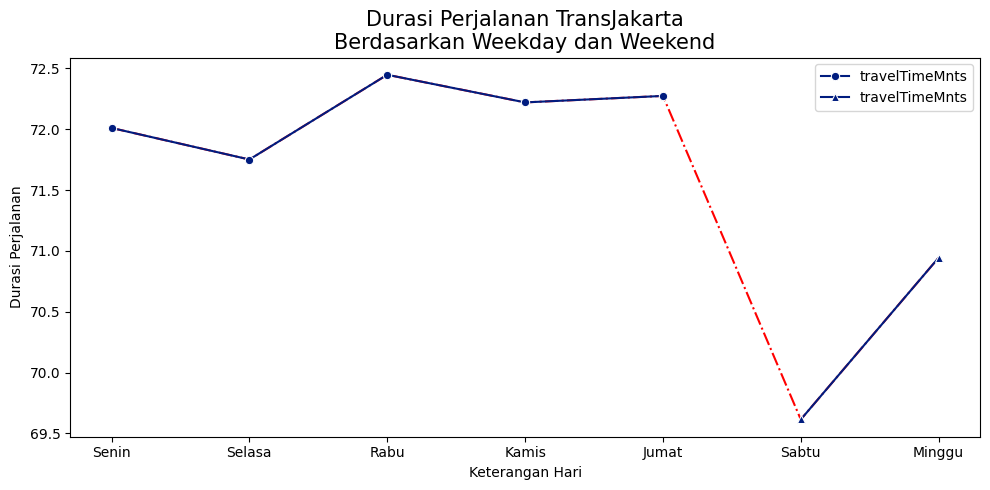

In [86]:
plt.figure(figsize=(10,5))
plt.plot(full, 'r-.')
sns.lineplot(weekdays, markers='o', palette='dark', legend='full')
sns.lineplot(weekends, markers='^', palette='dark', legend='full')
plt.xticks(range(7), ['Senin', 'Selasa', 'Rabu', 'Kamis', 'Jumat', 'Sabtu', 'Minggu'])
plt.xlabel('Keterangan Hari')
plt.ylabel('Durasi Perjalanan')
plt.title('Durasi Perjalanan TransJakarta\nBerdasarkan Weekday dan Weekend', size=15)

plt.tight_layout();

Durasi perjalanan juga bervariasi terhadap hari, dimana durasi perjalanan tertinggi berada pada hari Senin-Jumat dan di hari Sabtu cenderung lebih singkat kemudian kembali meningkat di hari Minggu.

### **Berdasarkan Demografi Penumpang *(Gender & Usia)***

1. Bagaimana demografi penumpang TransJakarta di bulan April tahun 2023?
2. Apakah terdapat perbedaan durasi perjalanan untuk kategori tertentu?

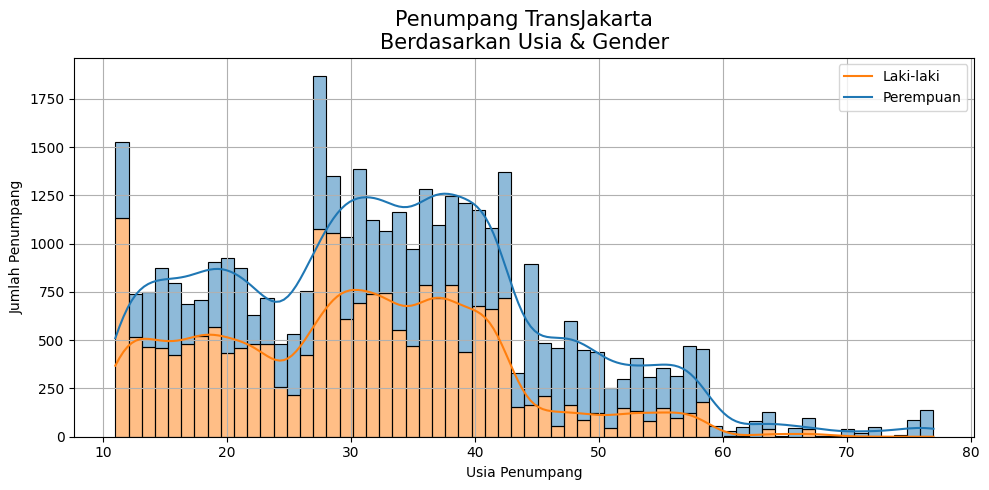

In [87]:
plt.figure(figsize=(10,5))
sns.histplot(df[['payCardSex','age']], x='age', hue='payCardSex', kde=True, multiple='stack', legend=True)
plt.xlabel('Usia Penumpang')
plt.ylabel('Jumlah Penumpang')
plt.title('Penumpang TransJakarta\nBerdasarkan Usia & Gender', size=15)
plt.legend(['Laki-laki','Perempuan'])
plt.grid()

plt.tight_layout();

In [88]:
df['payCardSex'].value_counts()

payCardSex
F    20046
M    17637
Name: count, dtype: int64

In [89]:
df.groupby('payCardSex')['age'].agg(['min','max','mean'])

,min,max,mean
payCardSex,,,
F,11,71,30.107303
M,11,77,36.116006


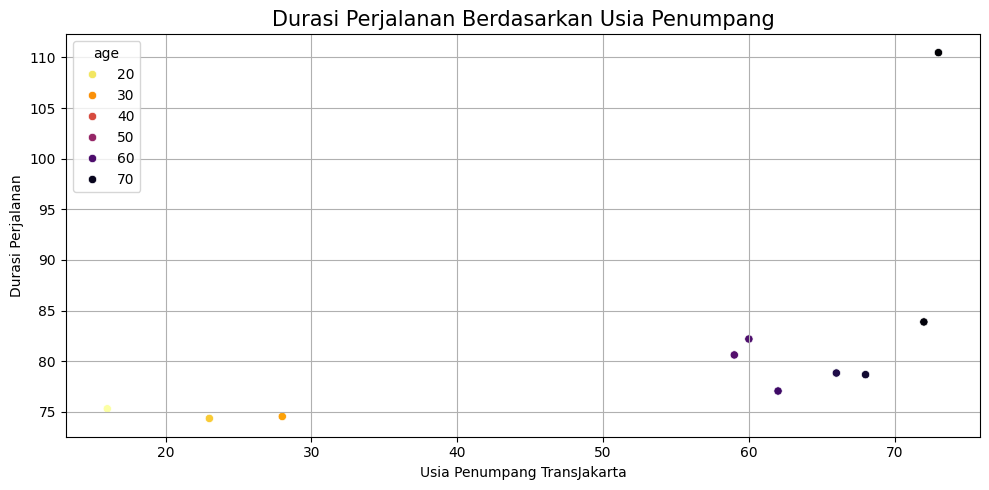

In [90]:
faktor_usia = pd.DataFrame(df.groupby('age')['travelTimeMnts'].mean().sort_values(ascending=False).head(10)).reset_index()

plt.figure(figsize=(10,5))
sns.scatterplot(faktor_usia, x='age', y='travelTimeMnts', markers='o', hue='age', palette='inferno_r')
plt.xlabel('Usia Penumpang TransJakarta')
plt.ylabel('Durasi Perjalanan')
plt.title('Durasi Perjalanan Berdasarkan Usia Penumpang', size=15)
plt.grid()

plt.tight_layout();

Dari visualisasi penumpang TransJakarta berdasarkan usia di atas kita dapat mengetahui:

- Penumpang TransJakarta didominasi oleh *wanita* dengan segmentasi usia dewasa. (25-45 tahun)
- Berdasarkan usia penumpang, durasi perjalanan tertinggi ada pada penumpang lansia.
- Temuan ini berpotensi untuk penyediaan **jalur prioritas** atau **dukungan tambahan** bagi segmen lansia agar dapat membantu durasi perjalanan yang mereka tempuh.

In [91]:
import plotly.express as px

age_bins = [0, 18, 30, 45, 60, 100]
age_labels = ['0-18', '19-30', '31-45', '46-60', '61+']
df['age_group'] = pd.cut(df['age'], bins=age_bins, labels=age_labels, right=False)

fig = px.sunburst(df, path=['age_group', 'payCardSex'], color='age',
                   title='Penumpang Transjakarta Berdasarkan Kelompok Usia dan Gender')
fig.show()

In [92]:
from scipy.stats import mannwhitneyu

h0 = 'Tidak terdapat perbedaan signifikan durasi perjalanan antara pria dan wanita.'
ha = 'Terdapat perbedaan signifikan durasi perjalanan antara pria dan wanita.'

pria = df[df['payCardSex'] == 'M']['payAmount']
wanita = df[df['payCardSex'] == 'F']['payAmount']

stat, pval = mannwhitneyu(pria, wanita, alternative='two-sided')

print(f'U-Statistic: {stat}')
print(f'p-value: {pval}')

if pval <= 0.05:
    print(f'Tolak H0')
    print(ha)
else:
    print(f'Gagal menolak H0')
    print(h0)

U-Statistic: 179317896.0
p-value: 0.006289253697569342
Tolak H0
Terdapat perbedaan signifikan durasi perjalanan antara pria dan wanita.


Berdasarkan visualisasi di atas kita dapat mengetahui bahwa:

- Mayoritas demografi penumpang TransJakarta adalah **wanita** dengan segmen rentang usia **remaja** hingga **dewasa**.
- Demografi penumpang TransJakarta segmen **lansia** (di atas 61 tahun) didominasi oleh *laki-laki* sebanyak **683 orang**.

### **Additional Insight**

TransJakarta baru `mulai beroperasi` dari jam `5 pagi` setiap harinya, dan `hanya dalam 5 menit pertama sejak beroperasi`, sudah tercatat `lebih dari 300 penumpang` melakukan *tap-in* dan menggunakan layanan TransJakarta.

In [93]:
display(
    df[(df['tapInTime'].dt.hour == 5) & (df['tapInTime'].dt.minute <= 5)].head(2),
    len(df[(df['tapInTime'].dt.hour == 5) & (df['tapInTime'].dt.minute <= 5)])
)

,payCardBank,payCardName,payCardSex,payCardBirthDate,corridorName,direction,tapInStopsName,tapInStopsLat,tapInStopsLon,stopStartSeq,tapInTime,tapOutStopsName,tapOutStopsLat,tapOutStopsLon,stopEndSeq,tapOutTime,payAmount,travelTimeMnts,hours,age,days,age_group
46,dki,Cager Setiawan,M,1965,Tongtek - Tebet Eco Park (TEP) - Cililitan,0.0,Sbr. Jln. Cikoko Timur I,-6.244364,106.85867,19,2023-04-03 05:04:52,St. Duren Kalibata 4,-6.255071,106.85506,23,2023-04-03 05:47:58,0.0,43.10,5,58,0,46-60
68,emoney,"Jamal Pudjiastuti, S.I.Kom",F,1981,Bekasi Timur - Cawang,1.0,Masjid Amar Maruf 2,-6.255062,107.02206,7,2023-04-03 05:02:15,Taman Margahayu 2,-6.248460,107.02153,10,2023-04-03 05:57:31,3500.0,55.27,5,42,0,31-45


323

### Complete DF

Kita akan kembali simpan dataset TransJakarta dengan tambahan kolom yang telah membantu kita sepanjang proses analisa dilakukan.

In [94]:
# df.to_csv('D:/Bonifasius/Capstone Project (Data Analysis)/cleaned_dataset/tj_complete.csv', index=False)

## Kesimpulan

Analisis eksploratif terhadap data perjalanan penumpang TransJakarta pada bulan April 2023 menghasilkan sejumlah temuan penting yang dapat dijadikan dasar pengambilan keputusan operasional. Berikut adalah rangkuman dari analisis yang telah dilakukan:

---

* Arah Tujuan: "Berangkat" / "Pulang":
    * TransJakarta perlu mempertimbangkan pengaturan jumlah armada yang berbeda antara arah berangkat dan pulang sesuai dengan jam sibuk harian.
* Waktu Keberangkatan:
    * Penyesuaian jadwal operasional dan transit antar bus disesuaikan dengan pola durasi dan volume penumpang khususnya pada rentang waktu jam-jam sibuk (*rush hour*).
* Analisis Berdasarkan Rute (Koridor):
    * Penempatan fokus utama kepada `10 rute dengan durasi dan penumpang tertinggi`, di baik dari sisi frekuensi maupun kapasitas bus, layak menjadi `prioritas awal` untuk `optimalisasi`.
* Demografi Penumpang:
    * Perbedaan ini membuka peluang untuk mengeksplorasi lebih lanjut `perbedaan kebutuhan` atau `preferensi pengguna` berdasarkan `gender` dan `usia`.

## Rekomendasi Umum

1. **Optimalisasi Armada** berdasarkan arah dan waktu seperti menerjunkan lebih banyak unit, khususnya saat pulang di sore hari.
2. **Prioritaskan Rute Kritis** (durasi tinggi + volume penumpang tinggi) untuk peningkatan frekuensi dan kapasitas bus.
3. **Monitoring Real-Time** untuk jam dan rute padat agar gangguan dapat direspons dengan cepat.
4. **Pelayanan Khusus** untuk pengguna lansia dan/atau perempuan (misal: [perbaikan toilet wanita](https://news.detik.com/berita/d-6810471/toilet-halte-transj-mh-thamrin-hi-tak-bisa-dipakai-begini-kondisinya)), menyesuaikan kebutuhan dalam durasi perjalanan yang mereka tempuh.

---

**Catatan**:
Analisis ini berdasarkan dataset layanan TransJakarta selama bulan April tahun 2023, sehingga representasi bisa berbeda di bulan atau periode atau tahun lainnya.
